# Meta-labeling and stacking

In [307]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from xgboost import XGBClassifier, plot_tree 
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 20 
plt.rcParams['axes.labelsize'] = 16 
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.family'] = 'serif'

'''Data Prep'''
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
'''Metrics'''
from sklearn.metrics import log_loss, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
'''Algos'''
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping


In [308]:
data = pd.read_excel('_NEM_w_dataset.xlsx')

In [309]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         538 non-null    datetime64[ns]
 1   High         538 non-null    float64       
 2   Low          538 non-null    float64       
 3   Open         538 non-null    float64       
 4   Close        538 non-null    float64       
 5   Volume       538 non-null    int64         
 6   Adj Close    538 non-null    float64       
 7   SMA          509 non-null    float64       
 8   EMA          538 non-null    float64       
 9   MACD         538 non-null    float64       
 10  Signal_line  538 non-null    float64       
 11  Up           537 non-null    float64       
 12  Down         537 non-null    float64       
 13  RSI          524 non-null    float64       
 14  L_period     525 non-null    float64       
 15  H_period     525 non-null    float64       
 16  Williams

In [310]:
data.head()

Date       High        Low       Open      Close    Volume  Adj Close  \
0 2011-01-01  62.209999  56.380001  61.849998  56.889999  47554400  47.000523   
1 2011-01-08  58.389999  55.189999  57.509998  55.720001  39475300  46.033920   
2 2011-01-15  57.009998  54.410000  56.470001  55.840000  34813600  46.133053   
3 2011-01-22  57.090000  54.299999  55.169998  55.000000  43193100  45.439075   
4 2011-01-29  58.099998  54.520000  54.900002  56.970001  35824000  47.066612   

   SMA        EMA      MACD  ...      Down  RSI  L_period  H_period  \
0  NaN  56.889999  0.000000  ...       NaN  NaN       NaN       NaN   
1  NaN  56.778571 -0.093333  ... -1.169998  NaN       NaN       NaN   
2  NaN  56.689183 -0.155821  ...  0.000000  NaN       NaN       NaN   
3  NaN  56.528309 -0.270012  ... -0.840000  NaN       NaN       NaN   
4  NaN  56.570375 -0.199250  ...  0.000000  NaN       NaN       NaN   

   Williams_R    Return  Vola  Min  Max  Target  
0         NaN       NaN   NaN  NaN  NaN       0  
1         NaN -0.020780   NaN  NaN  NaN       1  
2         NaN  0.002151   NaN  NaN  NaN       0  
3         NaN -0.015157   NaN  NaN  NaN       1  
4         NaN  0.035192   NaN  NaN  NaN       0  

[5 rows x 22 columns]

In [311]:
for i in range(1, 6):
    data['Lag_' + str(i)] = data['Return'].shift(i)
    
data['Class'] = data['Target'].copy()

In [312]:
data = data.dropna(axis=0)

In [313]:
data.head()

Date       High        Low       Open      Close    Volume  \
29 2011-07-23  59.570000  55.369999  59.130001  55.610001  34185000   
30 2011-07-30  58.049999  53.380001  55.619999  54.410000  49302100   
31 2011-08-06  58.529999  52.919998  55.990002  57.439999  69069100   
32 2011-08-13  60.810001  56.500000  57.580002  60.080002  35873900   
33 2011-08-20  63.549999  57.900002  61.000000  62.169998  46550000   

    Adj Close        SMA        EMA      MACD  ...      Vola        Min  \
29  46.255508  55.242667  55.242535 -0.018758  ...  0.035749  51.590000   
30  45.257370  55.160000  55.163246 -0.088151  ...  0.035082  51.590000   
31  47.777664  55.217333  55.380080  0.100196  ...  0.034037  51.590000   
32  49.973572  55.358667  55.827691  0.457217  ...  0.034766  52.270000   
33  51.711994  55.597667  56.431721  0.898448  ...  0.035184  53.740002   

          Max  Target     Lag_1     Lag_2     Lag_3     Lag_4     Lag_5  Class  
29  58.660000       0  0.022062  0.046736  0.018802  0.027735  0.013095      0  
30  58.660000       1 -0.053395  0.022062  0.046736  0.018802  0.027735      1  
31  58.660000       1 -0.021815 -0.053395  0.022062  0.046736  0.018802      1  
32  60.080002       1  0.054193 -0.021815 -0.053395  0.022062  0.046736      1  
33  62.169998       1  0.044936  0.054193 -0.021815 -0.053395  0.022062      1  

[5 rows x 28 columns]

In [314]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509 entries, 29 to 537
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         509 non-null    datetime64[ns]
 1   High         509 non-null    float64       
 2   Low          509 non-null    float64       
 3   Open         509 non-null    float64       
 4   Close        509 non-null    float64       
 5   Volume       509 non-null    int64         
 6   Adj Close    509 non-null    float64       
 7   SMA          509 non-null    float64       
 8   EMA          509 non-null    float64       
 9   MACD         509 non-null    float64       
 10  Signal_line  509 non-null    float64       
 11  Up           509 non-null    float64       
 12  Down         509 non-null    float64       
 13  RSI          509 non-null    float64       
 14  L_period     509 non-null    float64       
 15  H_period     509 non-null    float64       
 16  William

In [315]:
features = [
    #'Date',
    #'High',
     #'Low',
     #'Open',
     #'Close',
     #'Volume',
     #'Adj Close',
     #'SMA',
     #'EMA',
     'MACD',
     'Signal_line',
     ##'Up',
     ##'Down',
     'RSI',
     #'L_period',
     #'H_period',
     'Williams_R',
     ##'Return',
     'Vola',
     #'Min',
     #'Max',
     #'Target',
     'Lag_1',
     'Lag_2',
     'Lag_3',
     'Lag_4',
     'Lag_5',
     'Class'
]

In [316]:
data_original = data[features]

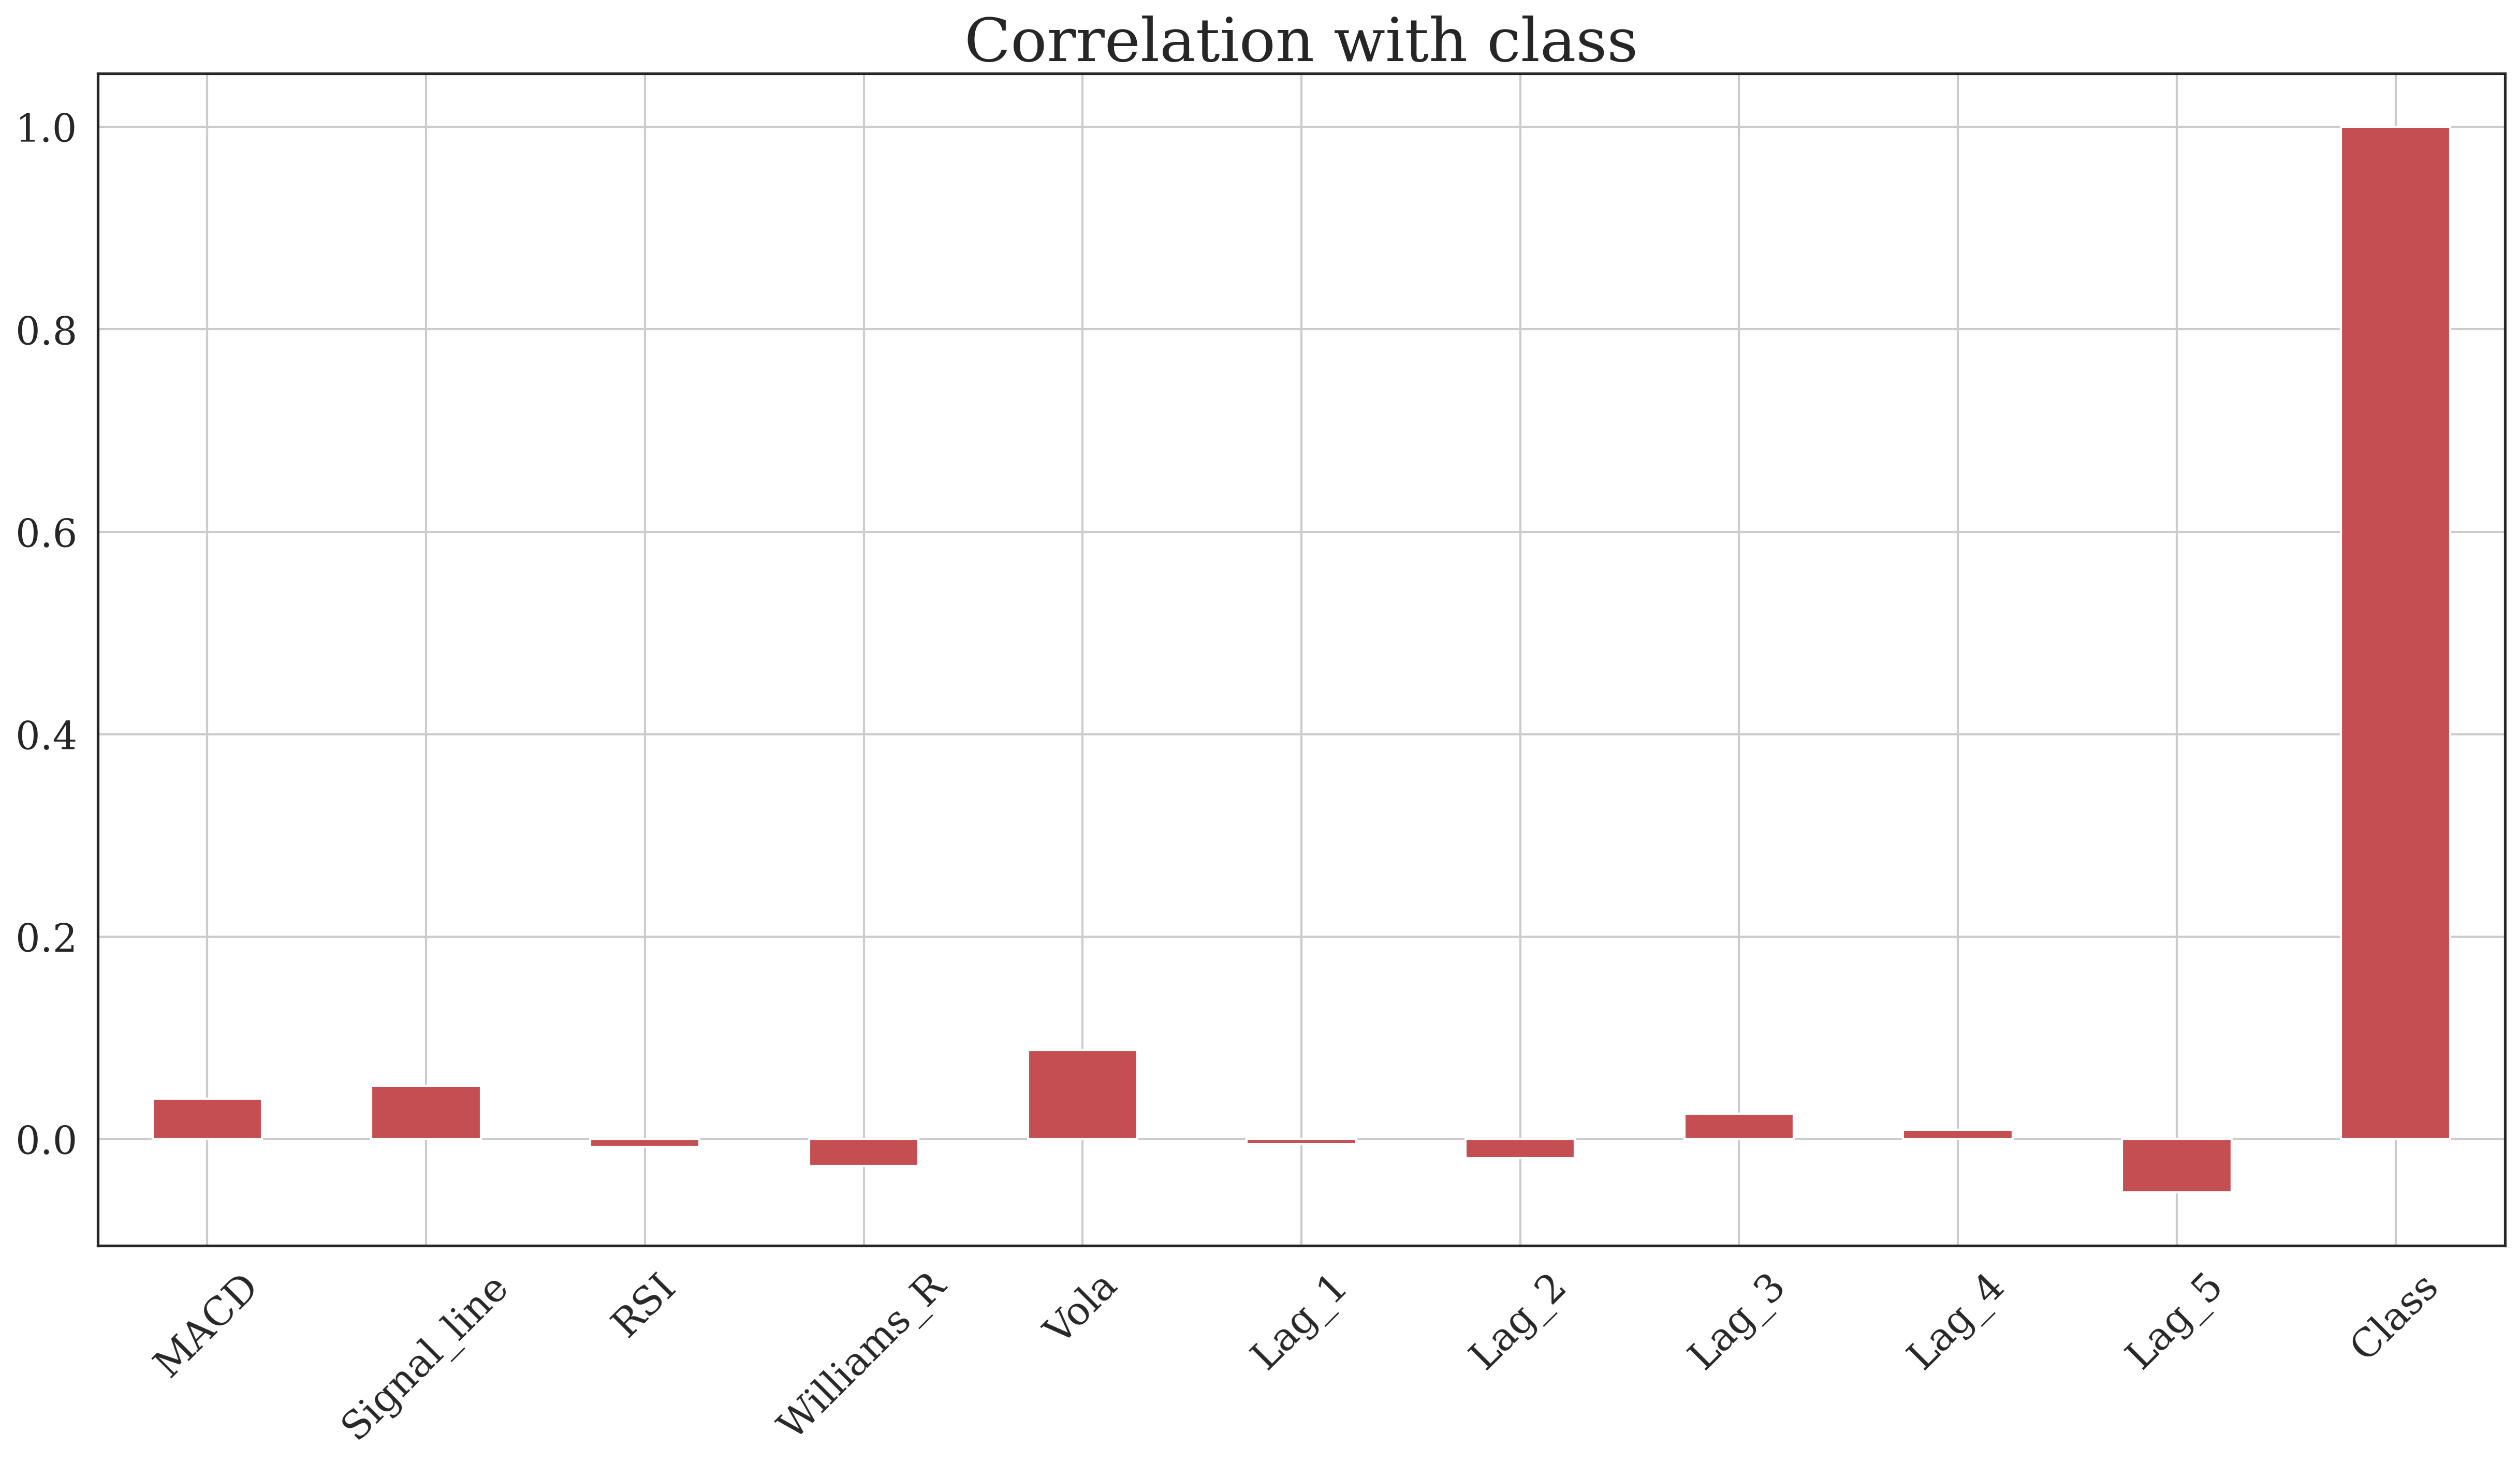

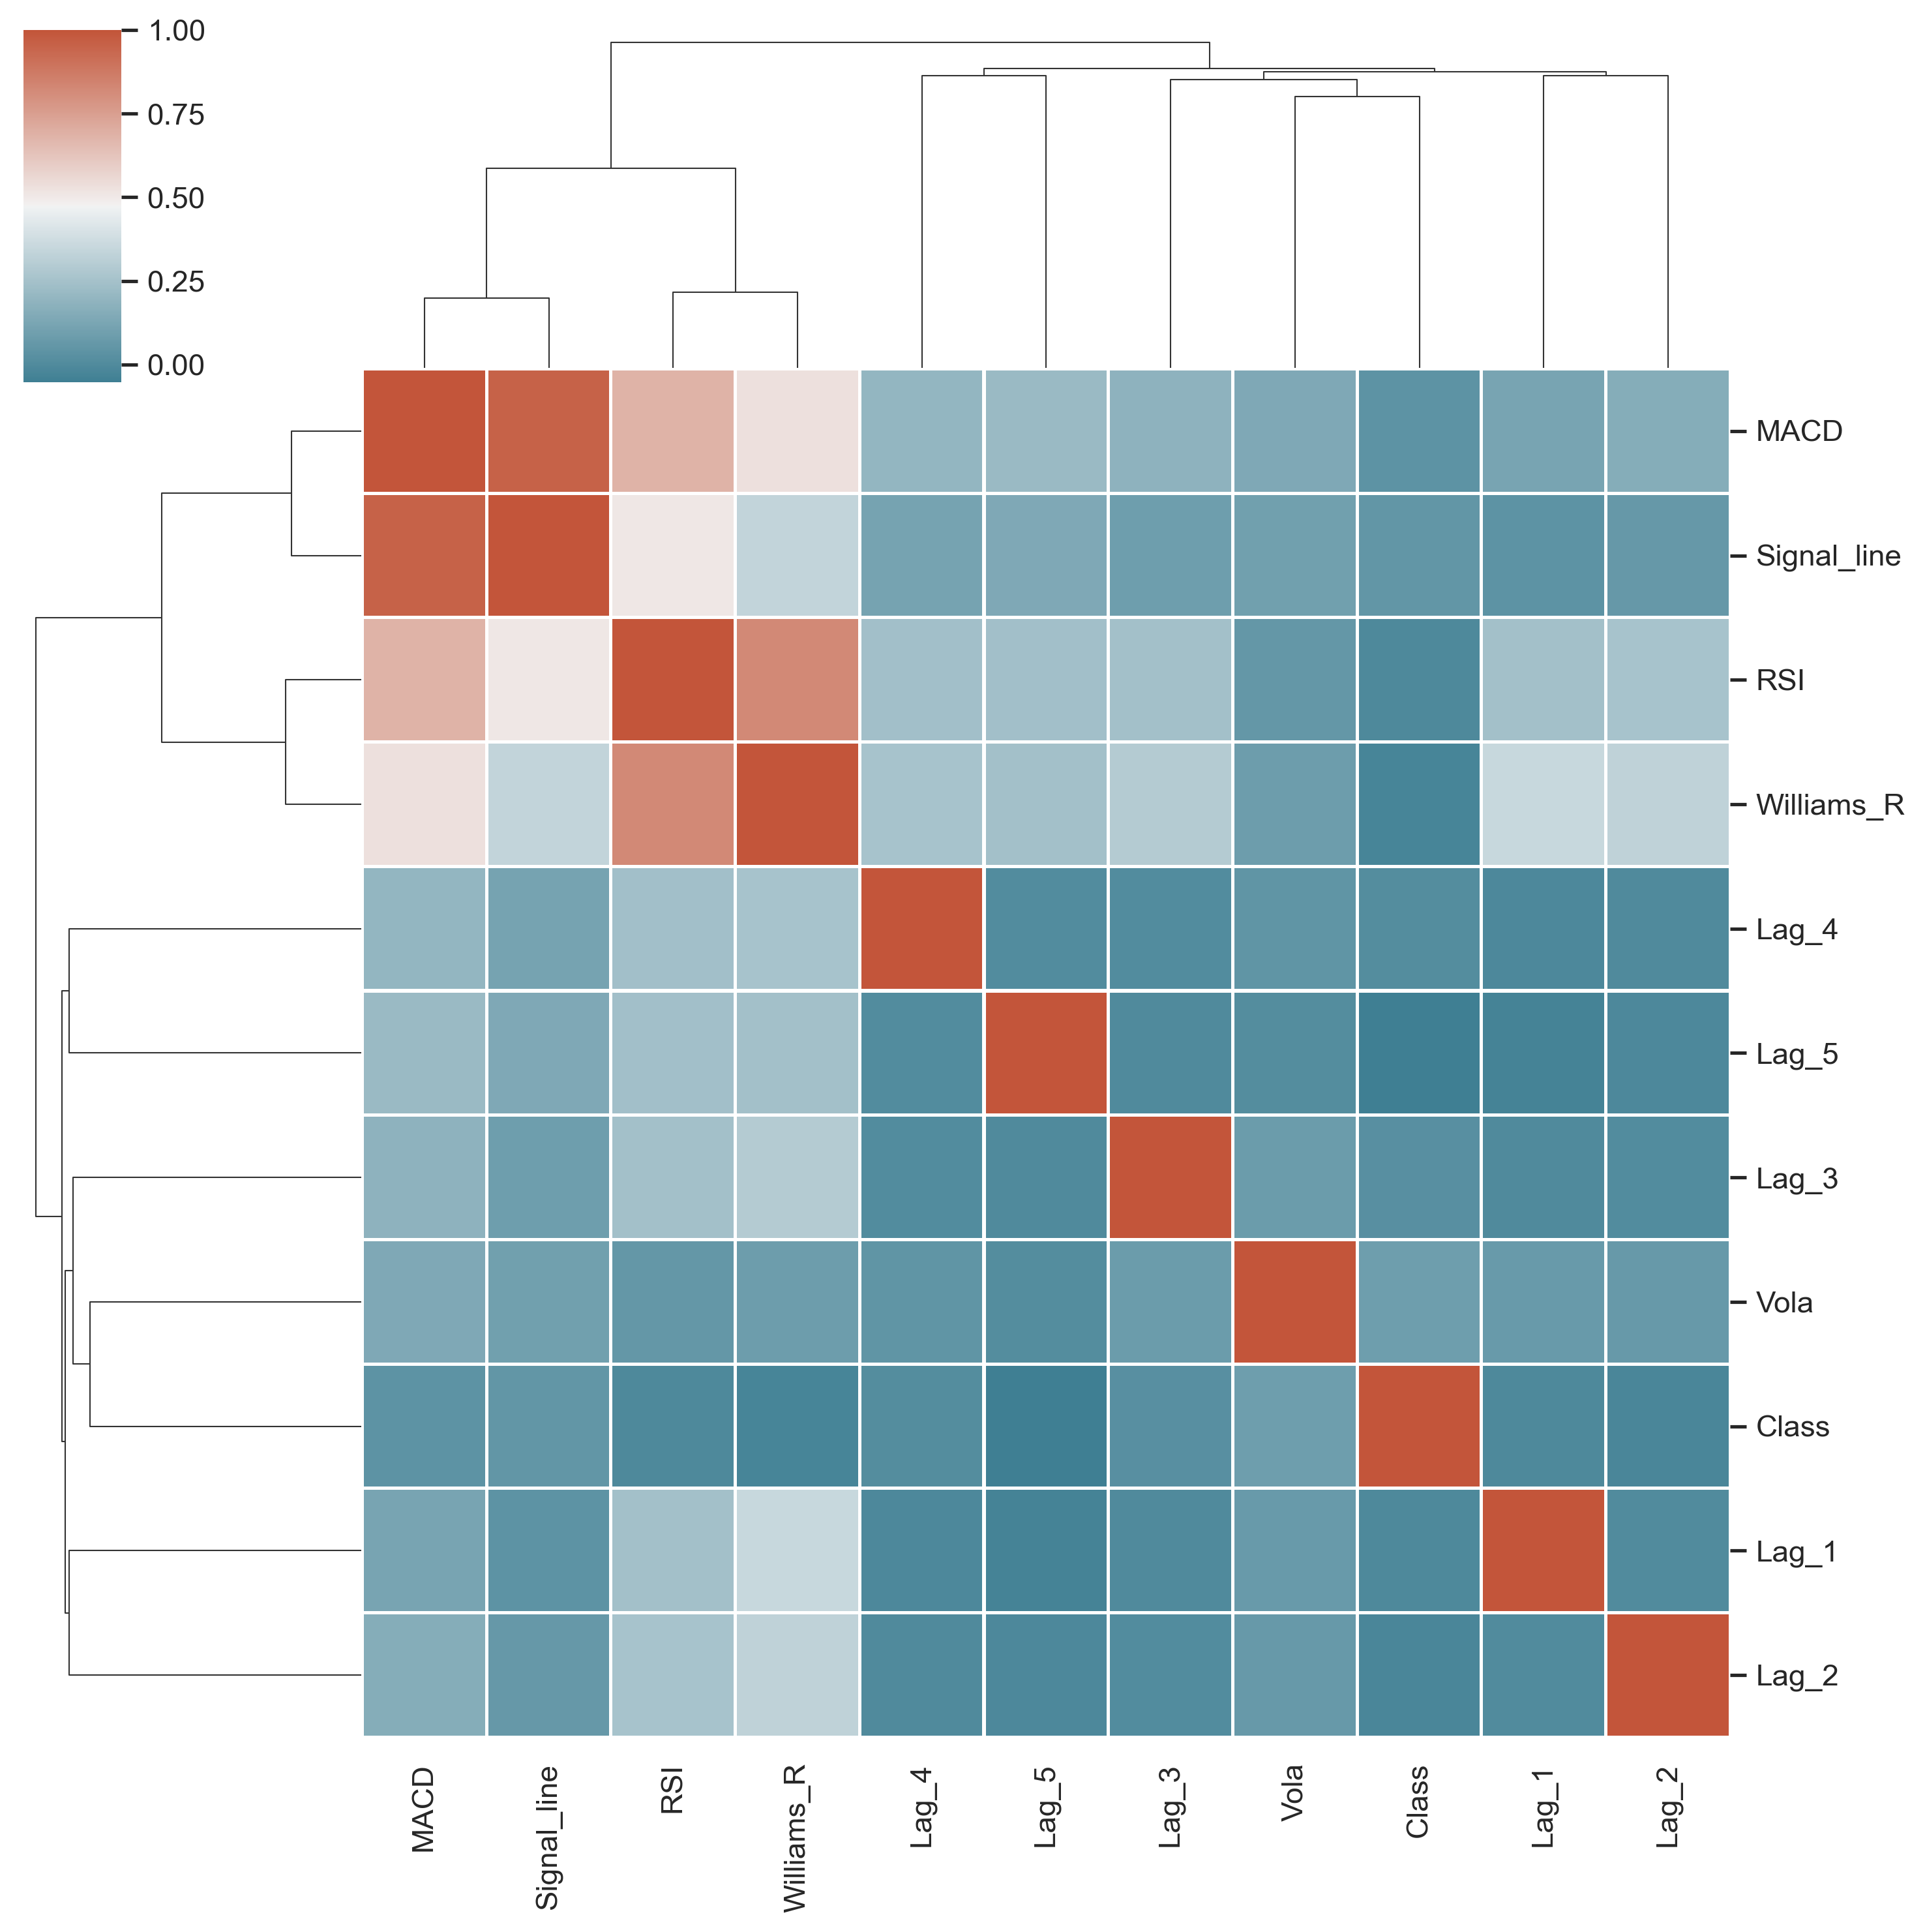

In [317]:
#see the cluster and corralation of features and classes
def plot_corr(data = data_original):
   
    ax1 = data.corrwith(data.Class).plot.bar(figsize = (20, 10),
         title = "Correlation with class",
         fontsize = 18, color='r',
         rot = 45, grid = True)
    ax1.title.set_size(28)
    
    sns.set(style="white")
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    
    corr =data.corr()
    sns.clustermap(corr,cmap=cmap,
                  linewidths=1,linecolor='w')
                 
plot_corr();

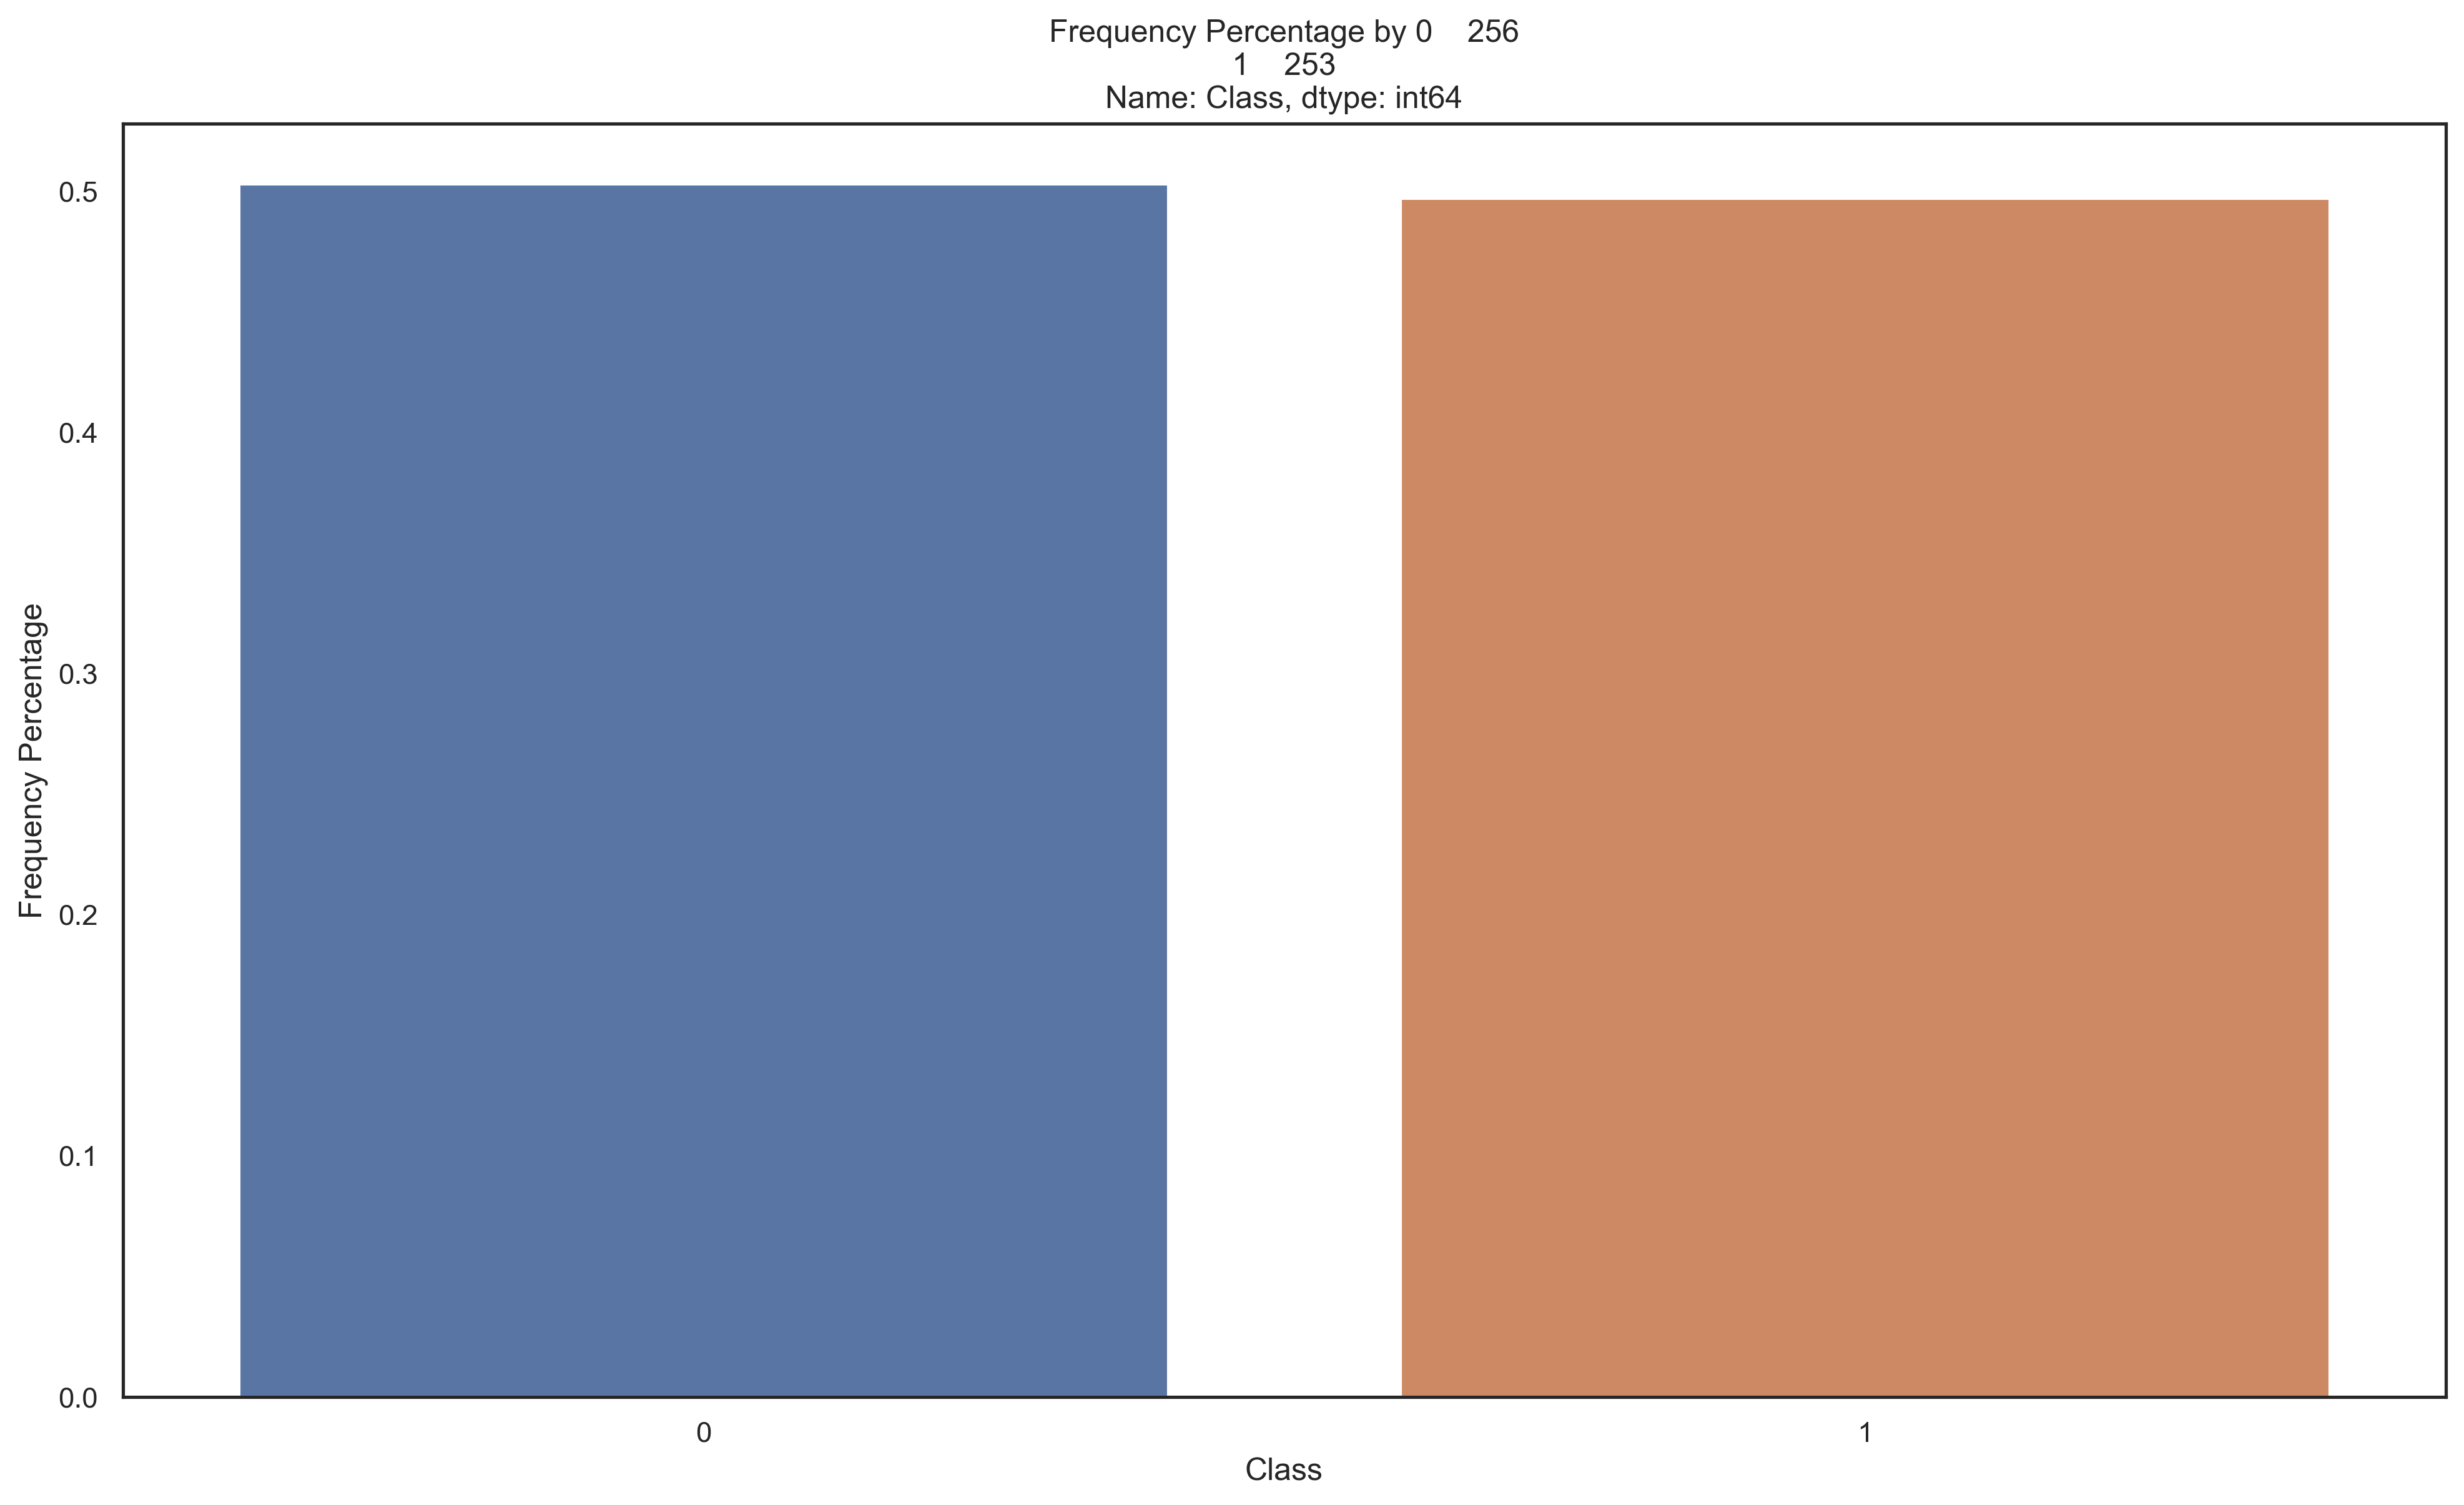

In [318]:
val_counts = data_original['Class'].value_counts()
ax = sns.barplot(x=val_counts.index,
                 y=val_counts/len(data_original))
ax.set(title=f'Frequency Percentage by {val_counts}',
       xlabel='Class',
       ylabel='Frequency Percentage');

In [319]:
def metrics_summary(true_label, prediction_prob, Threshold=0.5):
    
    #basically, slearn provides all the functions for metrics.
    average_precision = average_precision_score(true_label
    ,prediction_prob)
    fpr, tpr, thresholds = roc_curve(true_label, prediction_prob)
    areaUnderROC = auc(fpr, tpr)
    
    prediction_int = prediction_prob > Threshold
    
    accuracy = accuracy_score(true_label, prediction_int)
            
    print(f'accuracy: {accuracy}')
    print(f"average_precision: {average_precision}")
    print(f'areaUnderROC: {areaUnderROC } \n')
    print('*'*60)
    print(' '*20, 'classification_report')
    print('*'*60, "\n")
    print(classification_report(true_label, prediction_int))
    
    print('*'*60)
    print(' '*20, 'confusion_matrix \n')
    print('*'*60, "\n")
    display(confusion_matrix(true_label, prediction_int))
    print("\n")
    
    # precision_recall_curve and areaUnderROC 
    precision, recall, thresholds = precision_recall_curve( \
                                true_label, prediction_int)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
    
    ax1.step(recall, precision, color='k', alpha=0.7, where='post')
    ax1.fill_between(recall, precision, step='post', 
    alpha=0.3,color='k')
    ax1.set_xlabel('Recall', fontname="Arial", fontsize=24)
    ax1.set_ylabel('Precision', fontname="Arial", fontsize=24) 
    ax1.tick_params(labelsize=20)
     
    ax1.set_title('Precision-Recall curve: Average Precision \
    = {0:0.2f}'.format(average_precision), fontsize=24,
    fontname="Arial")        
               
    ax2.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    ax2.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    ax2.tick_params(labelsize=20)
    ax2.set_xlabel('False Positive Rate', fontname="Arial",
    fontsize=24)
    ax2.set_ylabel('True Positive Rate', fontname="Arial",
    fontsize=24)
    ax2.set_title('areaUnderROC = {0:0.2f}'\
            .format(areaUnderROC), fontsize=24, fontname="Arial",)    
    ax2.legend(loc="lower right", fontsize=24, fancybox=True) 
    # Adjust the subplot layout, because the logit one may take 
    # more space
    # than usual, due to y-tick labels like "1 - 10^{-3}"
    # plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10,
    # right=0.95, hspace=0.25,wspace=0.35)

In [320]:
#Normalize training and testing data
def scale_data(x_train, x_test=None):   
    features_to_scale = x_train.copy().columns
    scaler = pp.StandardScaler()
    print(scaler.fit(x_train[features_to_scale]))
    
    x_train.loc[:, features_to_scale] = scaler.transform(x_train[features_to_scale])
    
    #normalize test dataset with the mean and std of train data set 
    x_test.loc[:, features_to_scale] = scaler.transform(x_test[features_to_scale])
    
    return x_train, x_test

#seperate input and labels    
def get_x_y(data=data_original):
    data_x = data.copy().drop(['Class'], axis=1)
    data_y = data['Class'].copy()
    return data_x, data_y

#split the train and test data
def data_split(data_x, data_y):
    x_train, x_test, y_train, y_test = train_test_split(data_x,data_y,test_size=0.25,
                                       stratify=data_y,random_state=2020)
    return x_train, x_test, y_train, y_test

#put all together
def data_process(data=data_original):
    data_x, data_y = get_x_y(data)
    
    x_train, x_test, y_train, y_test = data_split(data_x, data_y)
    
    #do not touch the test data by any means!!!!
    x_train, x_test = scale_data(x_train, x_test)
    
    return  x_train, x_test, y_train, y_test

In [321]:
x_train, x_test_original, y_train, y_test_original = data_process(data_original)
x_train.shape, x_test_original.shape, y_train.shape, y_test_original.shape

StandardScaler()


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

((381, 10), (128, 10), (381,), (128,))

# Model 1 ( Logistic Regression)

In [322]:
def build_model_1(x_train, y_train):
    
    logitreg_parameters = {'C': np.power(10.0, np.arange(-9, 1)),
                           'solver' : ('lbfgs', 'liblinear') }
    
    model_1 = LogisticRegression(#solver='liblinear',
                                 class_weight='balanced', 
    #uses the values of y to automatically adjust weights
          
                                 warm_start=True,
    #reuse the solution of the previous call to fit as initialization
                                 max_iter = 300,
    #Maximum number of iterations taken for the solvers to converge.
                                 random_state=2020, 
    #so results can be reproduced
                                 )
    logitreg_grid = GridSearchCV(model_1, param_grid = logitreg_parameters,scoring = 'f1', n_jobs = 1, cv=5)          
                             
    logitreg_grid.fit(x_train, y_train)
    
    return logitreg_grid

model_1 = build_model_1(x_train, y_train)

In [323]:
model_1.best_score_

0.4504991697799917

In [324]:
model_1.best_estimator_

LogisticRegression(C=0.0001, class_weight='balanced', max_iter=300,
                   random_state=2020, warm_start=True)

In [325]:
# 0 and 1 two clasese
Threshold = 0.5
y_pred_prob_test_1 = model_1.predict_proba(x_test_original)[:,1]
# number of fraud is 123 in test dataset
y_pred_int_test_1 = y_pred_prob_test_1 > Threshold
pd.Series(y_pred_int_test_1).value_counts()

False    89
True     39
dtype: int64

accuracy: 0.4609375
average_precision: 0.4829727564102564
areaUnderROC: 0.4609375 

************************************************************
                     classification_report
************************************************************ 

              precision    recall  f1-score   support

           0       0.47      0.66      0.55        64
           1       0.44      0.27      0.33        64

    accuracy                           0.46       128
   macro avg       0.45      0.46      0.44       128
weighted avg       0.45      0.46      0.44       128

************************************************************
                     confusion_matrix 

************************************************************ 



array([[42, 22],
       [47, 17]], dtype=int64)

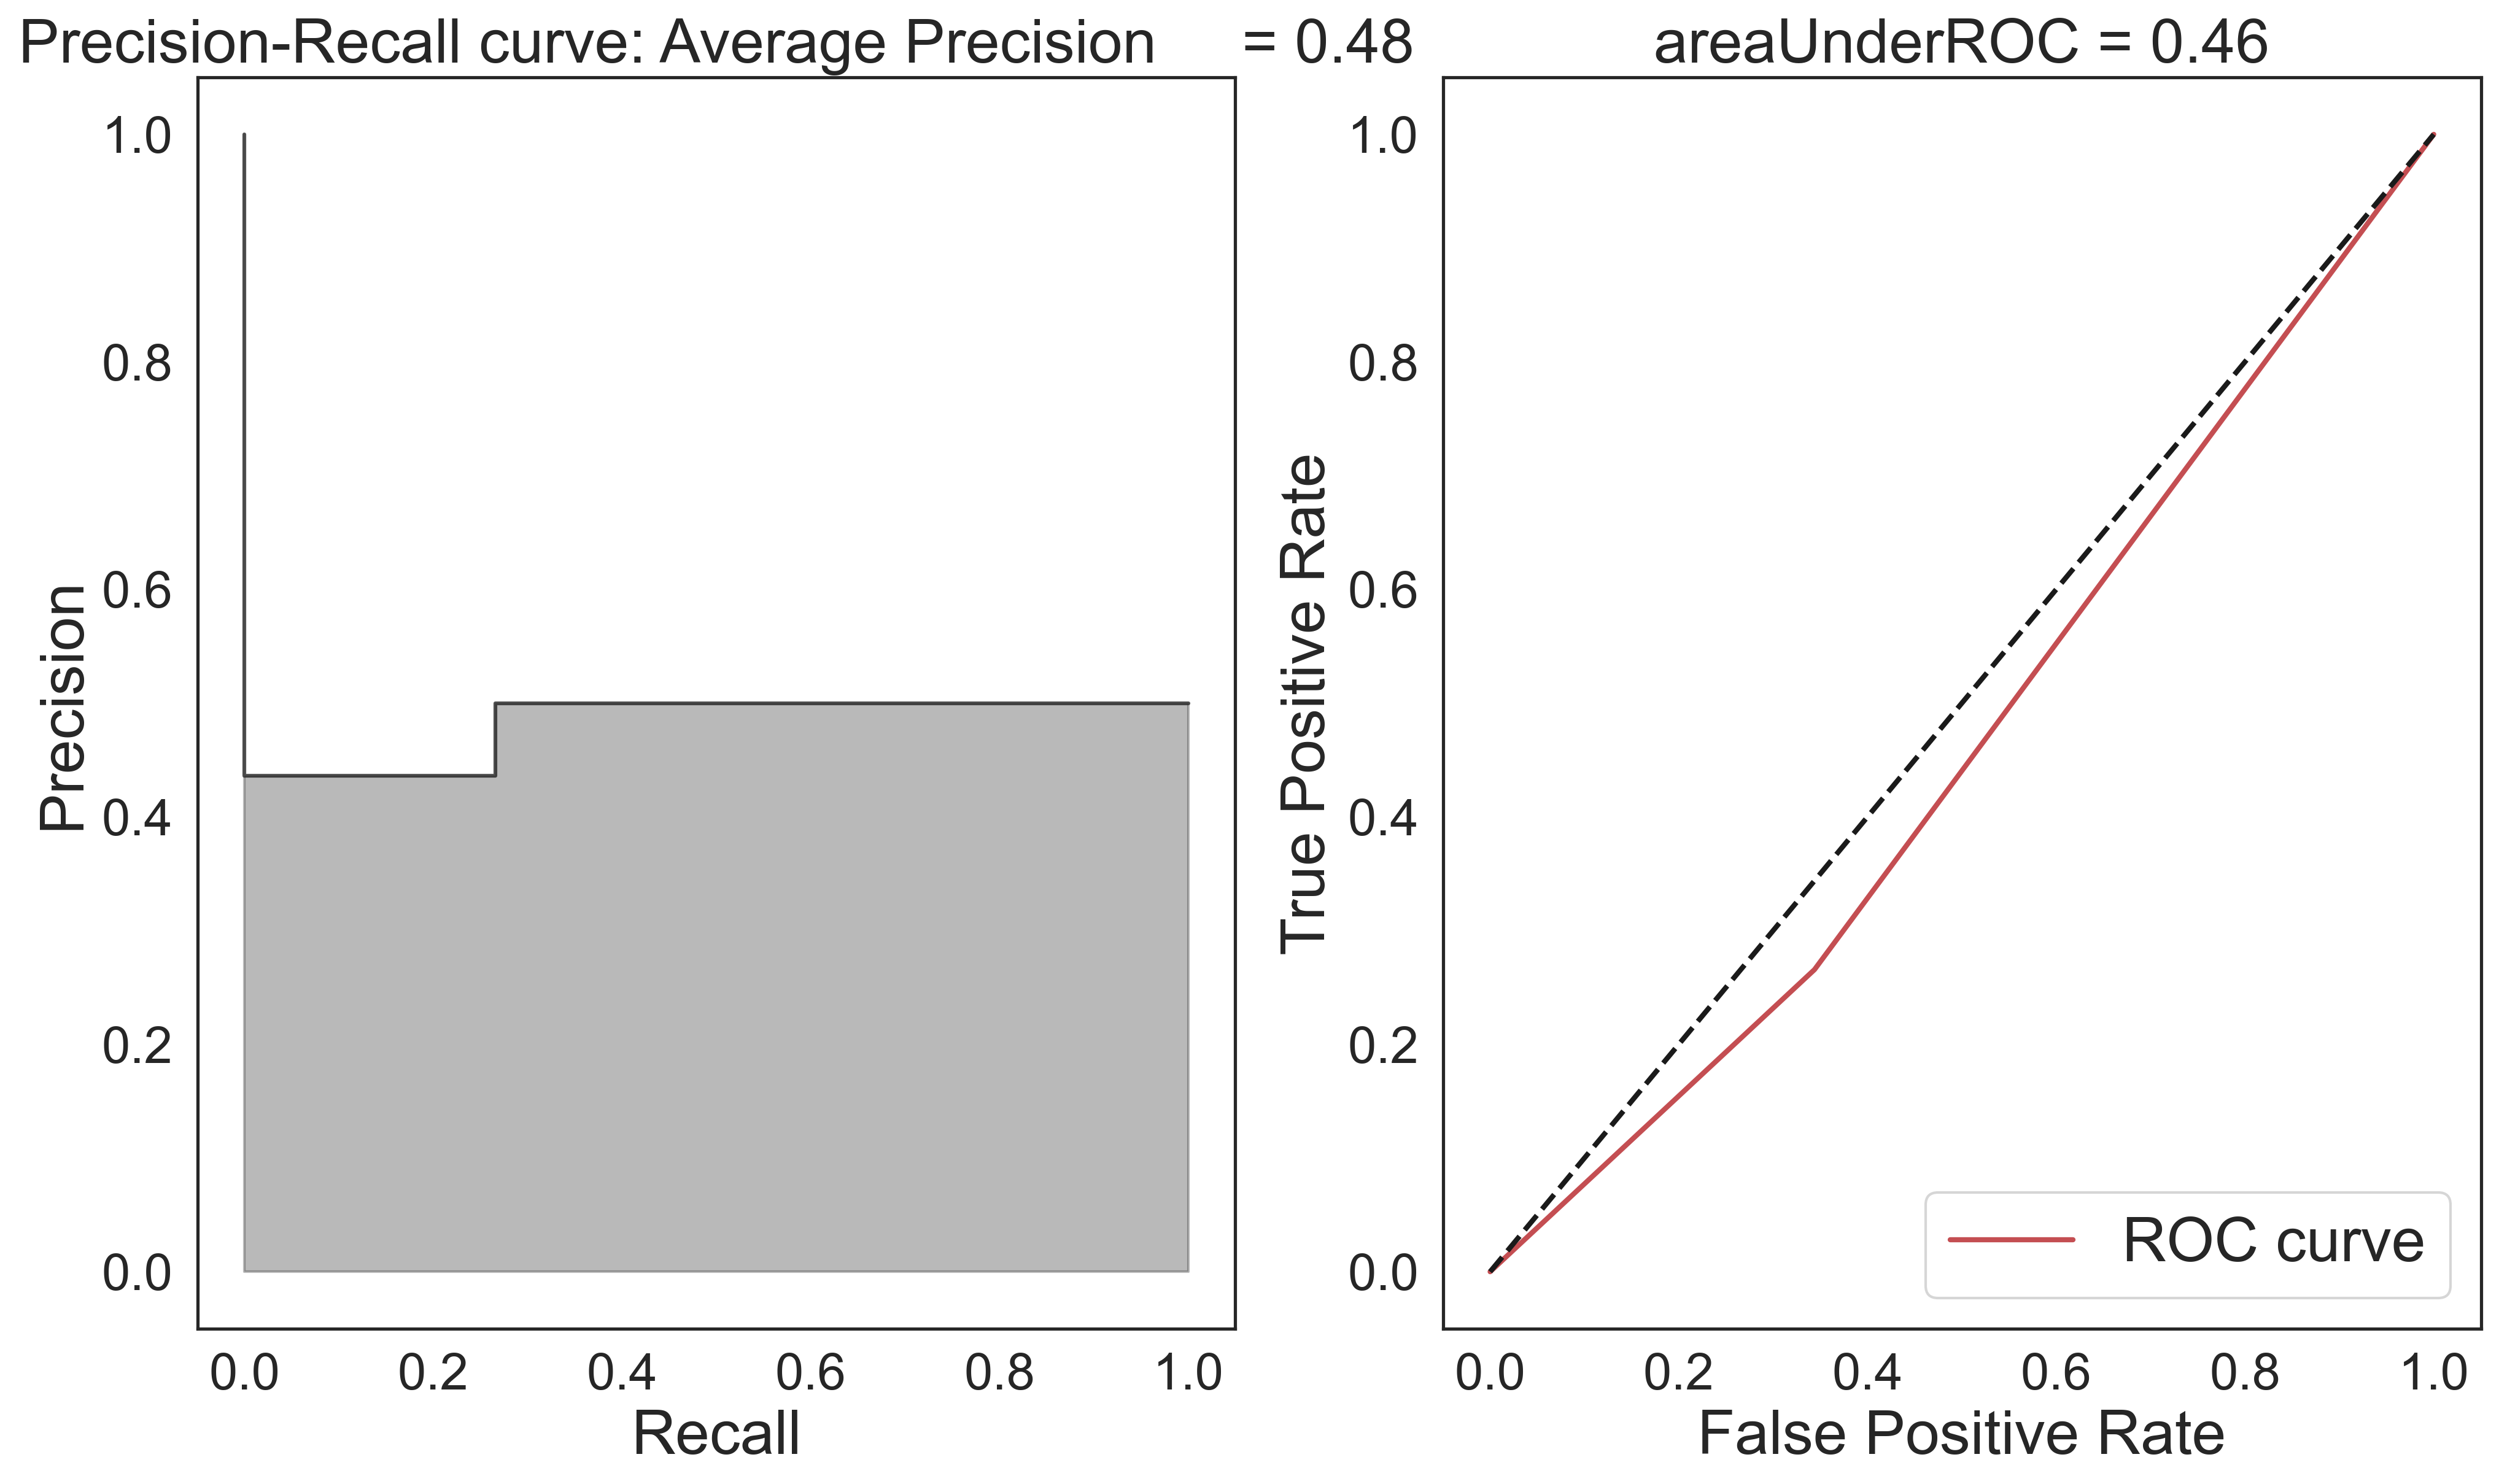

In [326]:
metrics_summary(y_test_original, y_pred_int_test_1)

# Model 2 (LightGBM)

In [327]:
#prepare data 
x_train_, x_cv, y_train_, y_cv = \
train_test_split(x_train, y_train,
                test_size=0.25,
                stratify=y_train,
                random_state=2020)
def build_model_2(x_train, y_train, x_cv, y_cv ):
    #most of the parsmeters are default
    params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16,
    'force_col_wise':True
    }
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_cv, y_cv, reference=lgb_train)
    model_2 = lgb.train(params_lightGB, lgb_train,
                    num_boost_round=2000,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=200,
                    verbose_eval=False)
    return model_2

x_train_.shape, y_train_.shape, x_cv.shape, y_cv.shape

((285, 10), (285,), (96, 10), (96,))

In [328]:
model_2 = build_model_2(x_train_, y_train_, x_cv, y_cv)
y_pred_prob_test_2 = model_2.predict(x_test_original)
y_pred_int_test_2 = y_pred_prob_test_2 > Threshold
pd.DataFrame(y_pred_int_test_2).value_counts()

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

False    107
True      21
dtype: int64

accuracy: 0.4921875
average_precision: 0.4962797619047619
areaUnderROC: 0.4921875 

************************************************************
                     classification_report
************************************************************ 

              precision    recall  f1-score   support

           0       0.50      0.83      0.62        64
           1       0.48      0.16      0.24        64

    accuracy                           0.49       128
   macro avg       0.49      0.49      0.43       128
weighted avg       0.49      0.49      0.43       128

************************************************************
                     confusion_matrix 

************************************************************ 



array([[53, 11],
       [54, 10]], dtype=int64)

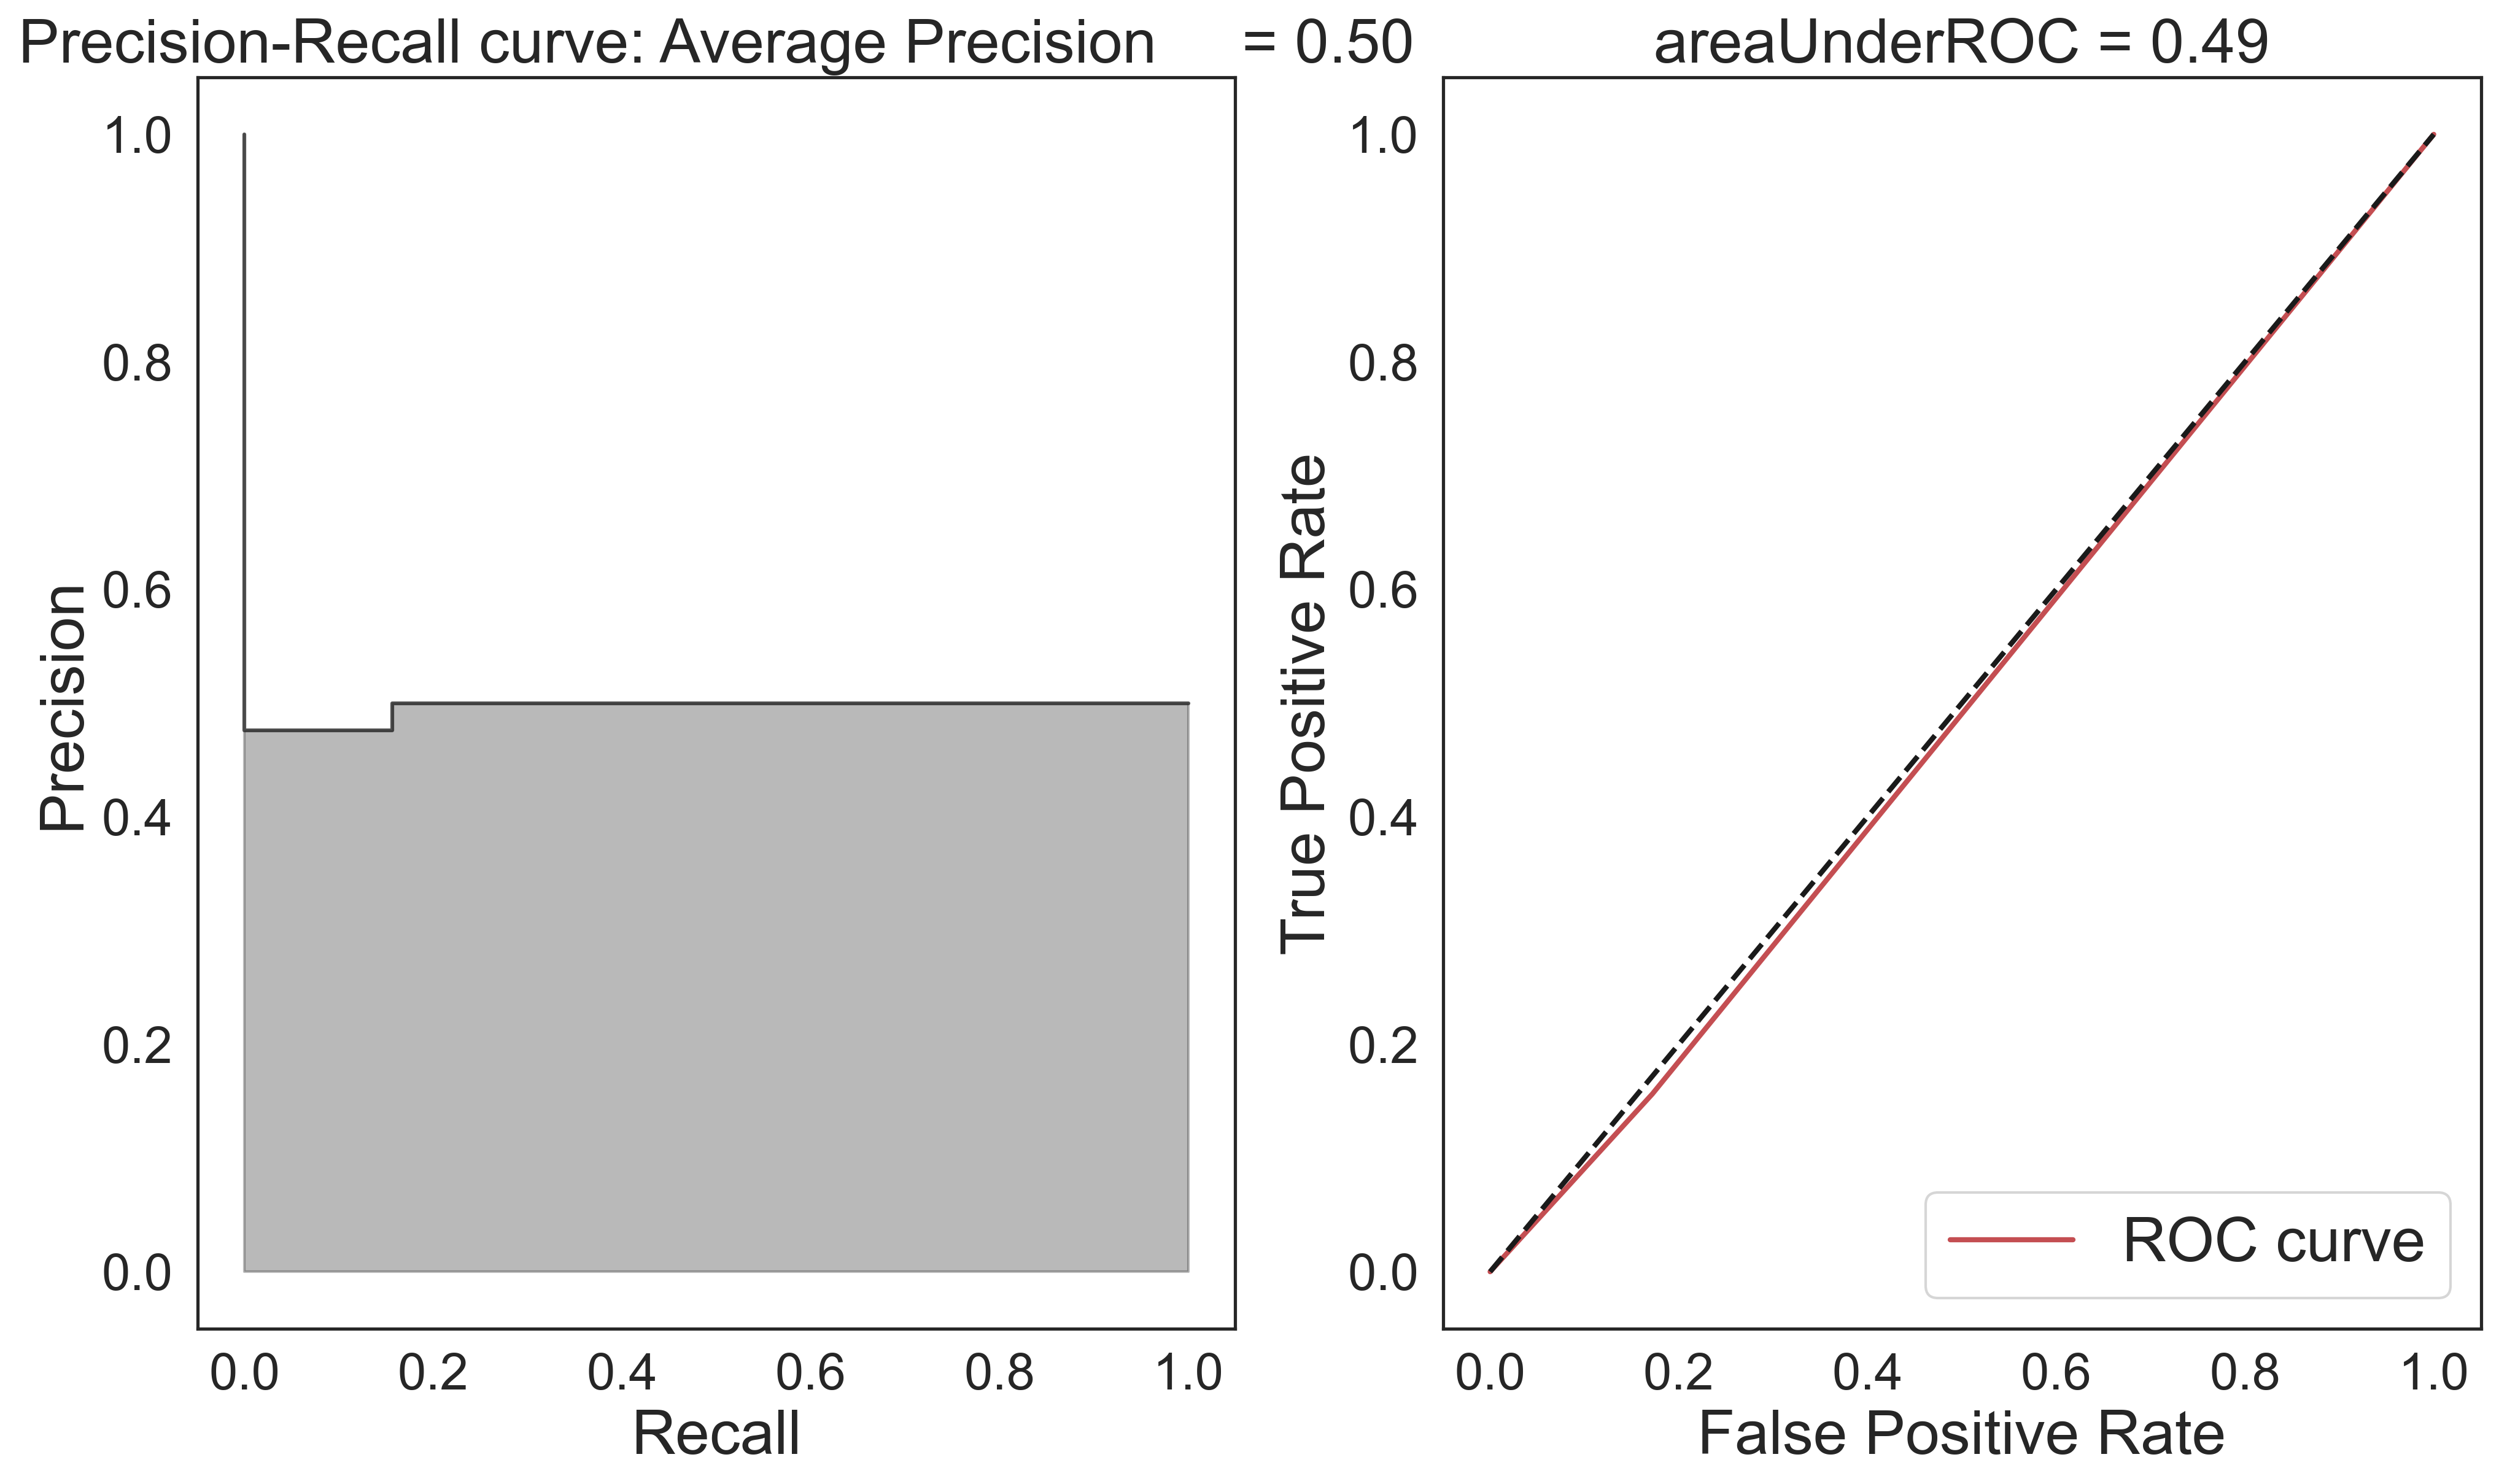

In [329]:
metrics_summary(y_test_original, y_pred_int_test_2)

# Model 3 (XGBoost)

In [330]:
def build_model_3(x_train, y_train):
    
    xgb_parameters = {'learning_rate': [0.05],
                      'n_estimators' : [600],
                      'max_depth': [3]
                     }
    
    model_3 = XGBClassifier(random_state=2020)
    
    xgb_grid = GridSearchCV(model_3, param_grid = xgb_parameters, scoring = 'f1', n_jobs = 1, cv=5)          
                             
    xgb_grid.fit(x_train, y_train)
    
    return xgb_grid

model_3 = build_model_3(x_train, y_train)



C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:56:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:56:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:56:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:56:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:56:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:56:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [331]:
model_3.best_score_

0.5049353293348637

In [332]:
model_3.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=8, num_parallel_tree=1,
              random_state=2020, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [333]:
# 0 and 1 two clasese
Threshold = 0.5
y_pred_prob_test_3 = model_3.predict_proba(x_test_original)[:,1]
# number of fraud is 123 in test dataset
y_pred_int_test_3 = y_pred_prob_test_3 > Threshold
pd.Series(y_pred_int_test_3).value_counts()

False    69
True     59
dtype: int64

accuracy: 0.5390625
average_precision: 0.521186440677966
areaUnderROC: 0.5390625 

************************************************************
                     classification_report
************************************************************ 

              precision    recall  f1-score   support

           0       0.54      0.58      0.56        64
           1       0.54      0.50      0.52        64

    accuracy                           0.54       128
   macro avg       0.54      0.54      0.54       128
weighted avg       0.54      0.54      0.54       128

************************************************************
                     confusion_matrix 

************************************************************ 



array([[37, 27],
       [32, 32]], dtype=int64)

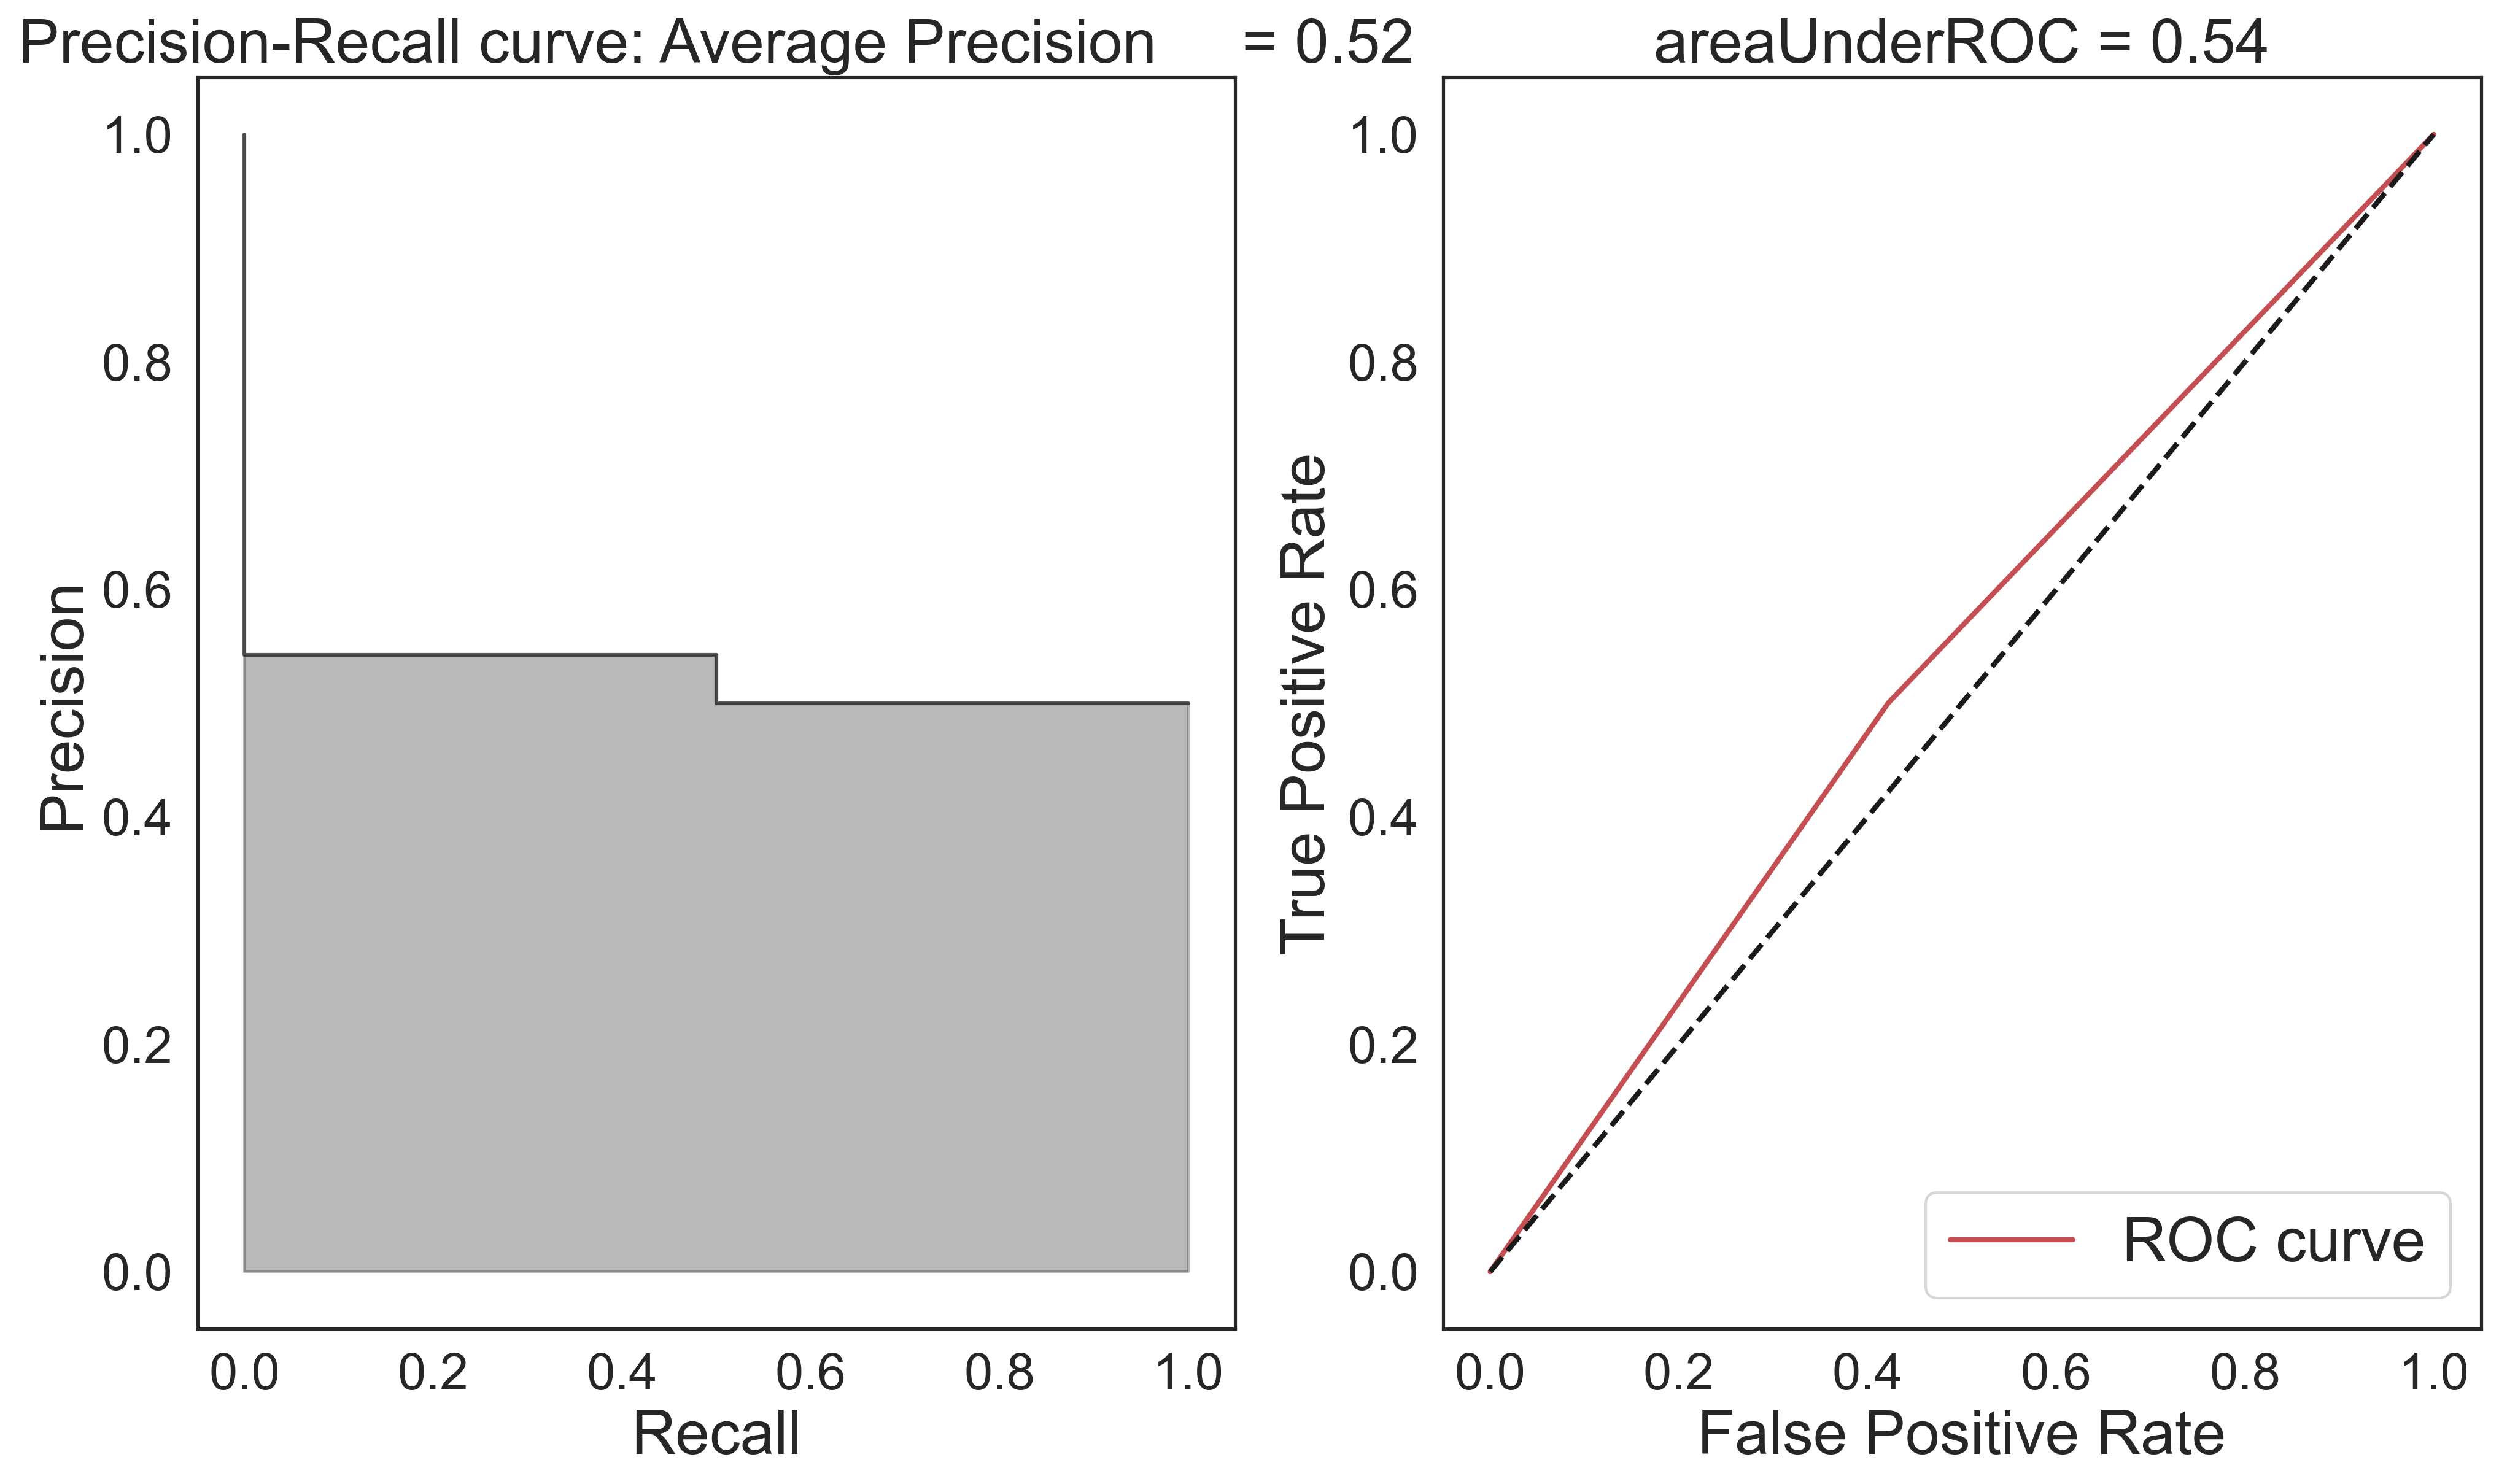

In [334]:
metrics_summary(y_test_original, y_pred_int_test_3)

# Stacking

In [335]:
def data_stack( x, y, m_1=model_1, m_2=model_2, m_3=model_3):
    #All required parameters must be placed before any default arguments.
    '''
    x: features
    y: labels
    m_1, m_2, m_3: 3 models
    
    '''
    # build a container to hold all the prediction from 3 models
    pred_all = pd.DataFrame(data=[], index=y.index)
    pred_1 = m_1.predict_proba(x)[:,1]
    pred_1_df = pd.DataFrame(pred_1, index=y.index)
    pred_2 = m_2.predict(x,num_iteration=m_2.best_iteration)
                    
    pred_2_df = pd.DataFrame(pred_2, index=y.index)
    pred_3 = m_3.predict(x).reshape(x.shape[0]) #to 1D shape
    pred_3_df = pd.DataFrame(pred_3, index=y.index)
   # join all the predictions together
    pred_all = pred_all.join(pred_1_df.astype(float),
                             how='left',rsuffix="0").join(pred_2_df.astype(float),
                             how='left',rsuffix="1").join(pred_3_df.astype(float),
                             how='left',rsuffix="2")
    pred_all.columns = ['pred_1', 'pred_2','pred_3']
    # final training data will be the merge of training data 
    # and all the predictions
    x_pred = x.merge(pred_all, left_index=True, right_index=True)
    
    return x_pred

In [336]:
x_train_stack = data_stack(x_train, y_train)
x_train_stack.shape

(381, 13)

In [337]:
x_test_stack = data_stack(x_test_original, y_test_original)
x_test_stack.shape

(128, 13)

In [338]:
x_train_stack.head()

MACD  Signal_line       RSI  Williams_R      Vola     Lag_1  \
75  -1.573556    -1.781380 -1.013761    0.081445 -0.620975  0.022583   
228  0.425946     0.215373  0.487387    1.190576 -0.278003  1.290530   
417 -0.273044    -0.555501  1.090741    1.263777 -1.069813  0.597686   
262 -0.369274    -0.464493 -0.343390   -0.563361  1.154277  0.053522   
265 -0.052976    -0.352662  0.806418    1.603152  2.639099  3.711841   

        Lag_2     Lag_3     Lag_4     Lag_5    pred_1    pred_2  pred_3  
75   0.595394  1.417066  0.059661 -0.378056  0.498989  0.492242     0.0  
228 -0.348001  1.212985  1.086802  1.022413  0.499683  0.488795     1.0  
417  0.128054 -0.036358  0.582526 -0.108262  0.498973  0.492243     1.0  
262 -0.608570  0.949363 -1.521029 -1.351775  0.501024  0.492110     0.0  
265 -1.195495 -0.342377 -0.012217 -0.625380  0.501425  0.515996     1.0

In [339]:
#normalize training and testing data
x_train_stack, x_test_stack = scale_data(x_train_stack,  x_test_stack)
#split the traning data to train and validation
x_train_stack_, x_cv_stack, y_train_, y_cv_ = \
train_test_split(x_train_stack, y_train,
                test_size=0.25,
                stratify=y_train,
                random_state=2020)
#stratify mean samplling with the ratio of each class percentage in #all data.
x_train_stack_.shape, x_cv_stack.shape, y_train_.shape,  y_cv.shape

StandardScaler()


((285, 13), (96, 13), (285,), (96,))

In [340]:
model_2_stack = build_model_2(x_train_stack_, y_train_, x_cv_stack, y_cv_)
y_pred_prob_test_2_stack = model_2_stack.predict(x_test_stack)
y_pred_int_test_2_stack = y_pred_prob_test_2_stack > Threshold
pd.DataFrame(y_pred_int_test_2_stack).value_counts()

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

False    69
True     59
dtype: int64

accuracy: 0.5390625
average_precision: 0.521186440677966
areaUnderROC: 0.5390625 

************************************************************
                     classification_report
************************************************************ 

              precision    recall  f1-score   support

           0       0.54      0.58      0.56        64
           1       0.54      0.50      0.52        64

    accuracy                           0.54       128
   macro avg       0.54      0.54      0.54       128
weighted avg       0.54      0.54      0.54       128

************************************************************
                     confusion_matrix 

************************************************************ 



array([[37, 27],
       [32, 32]], dtype=int64)

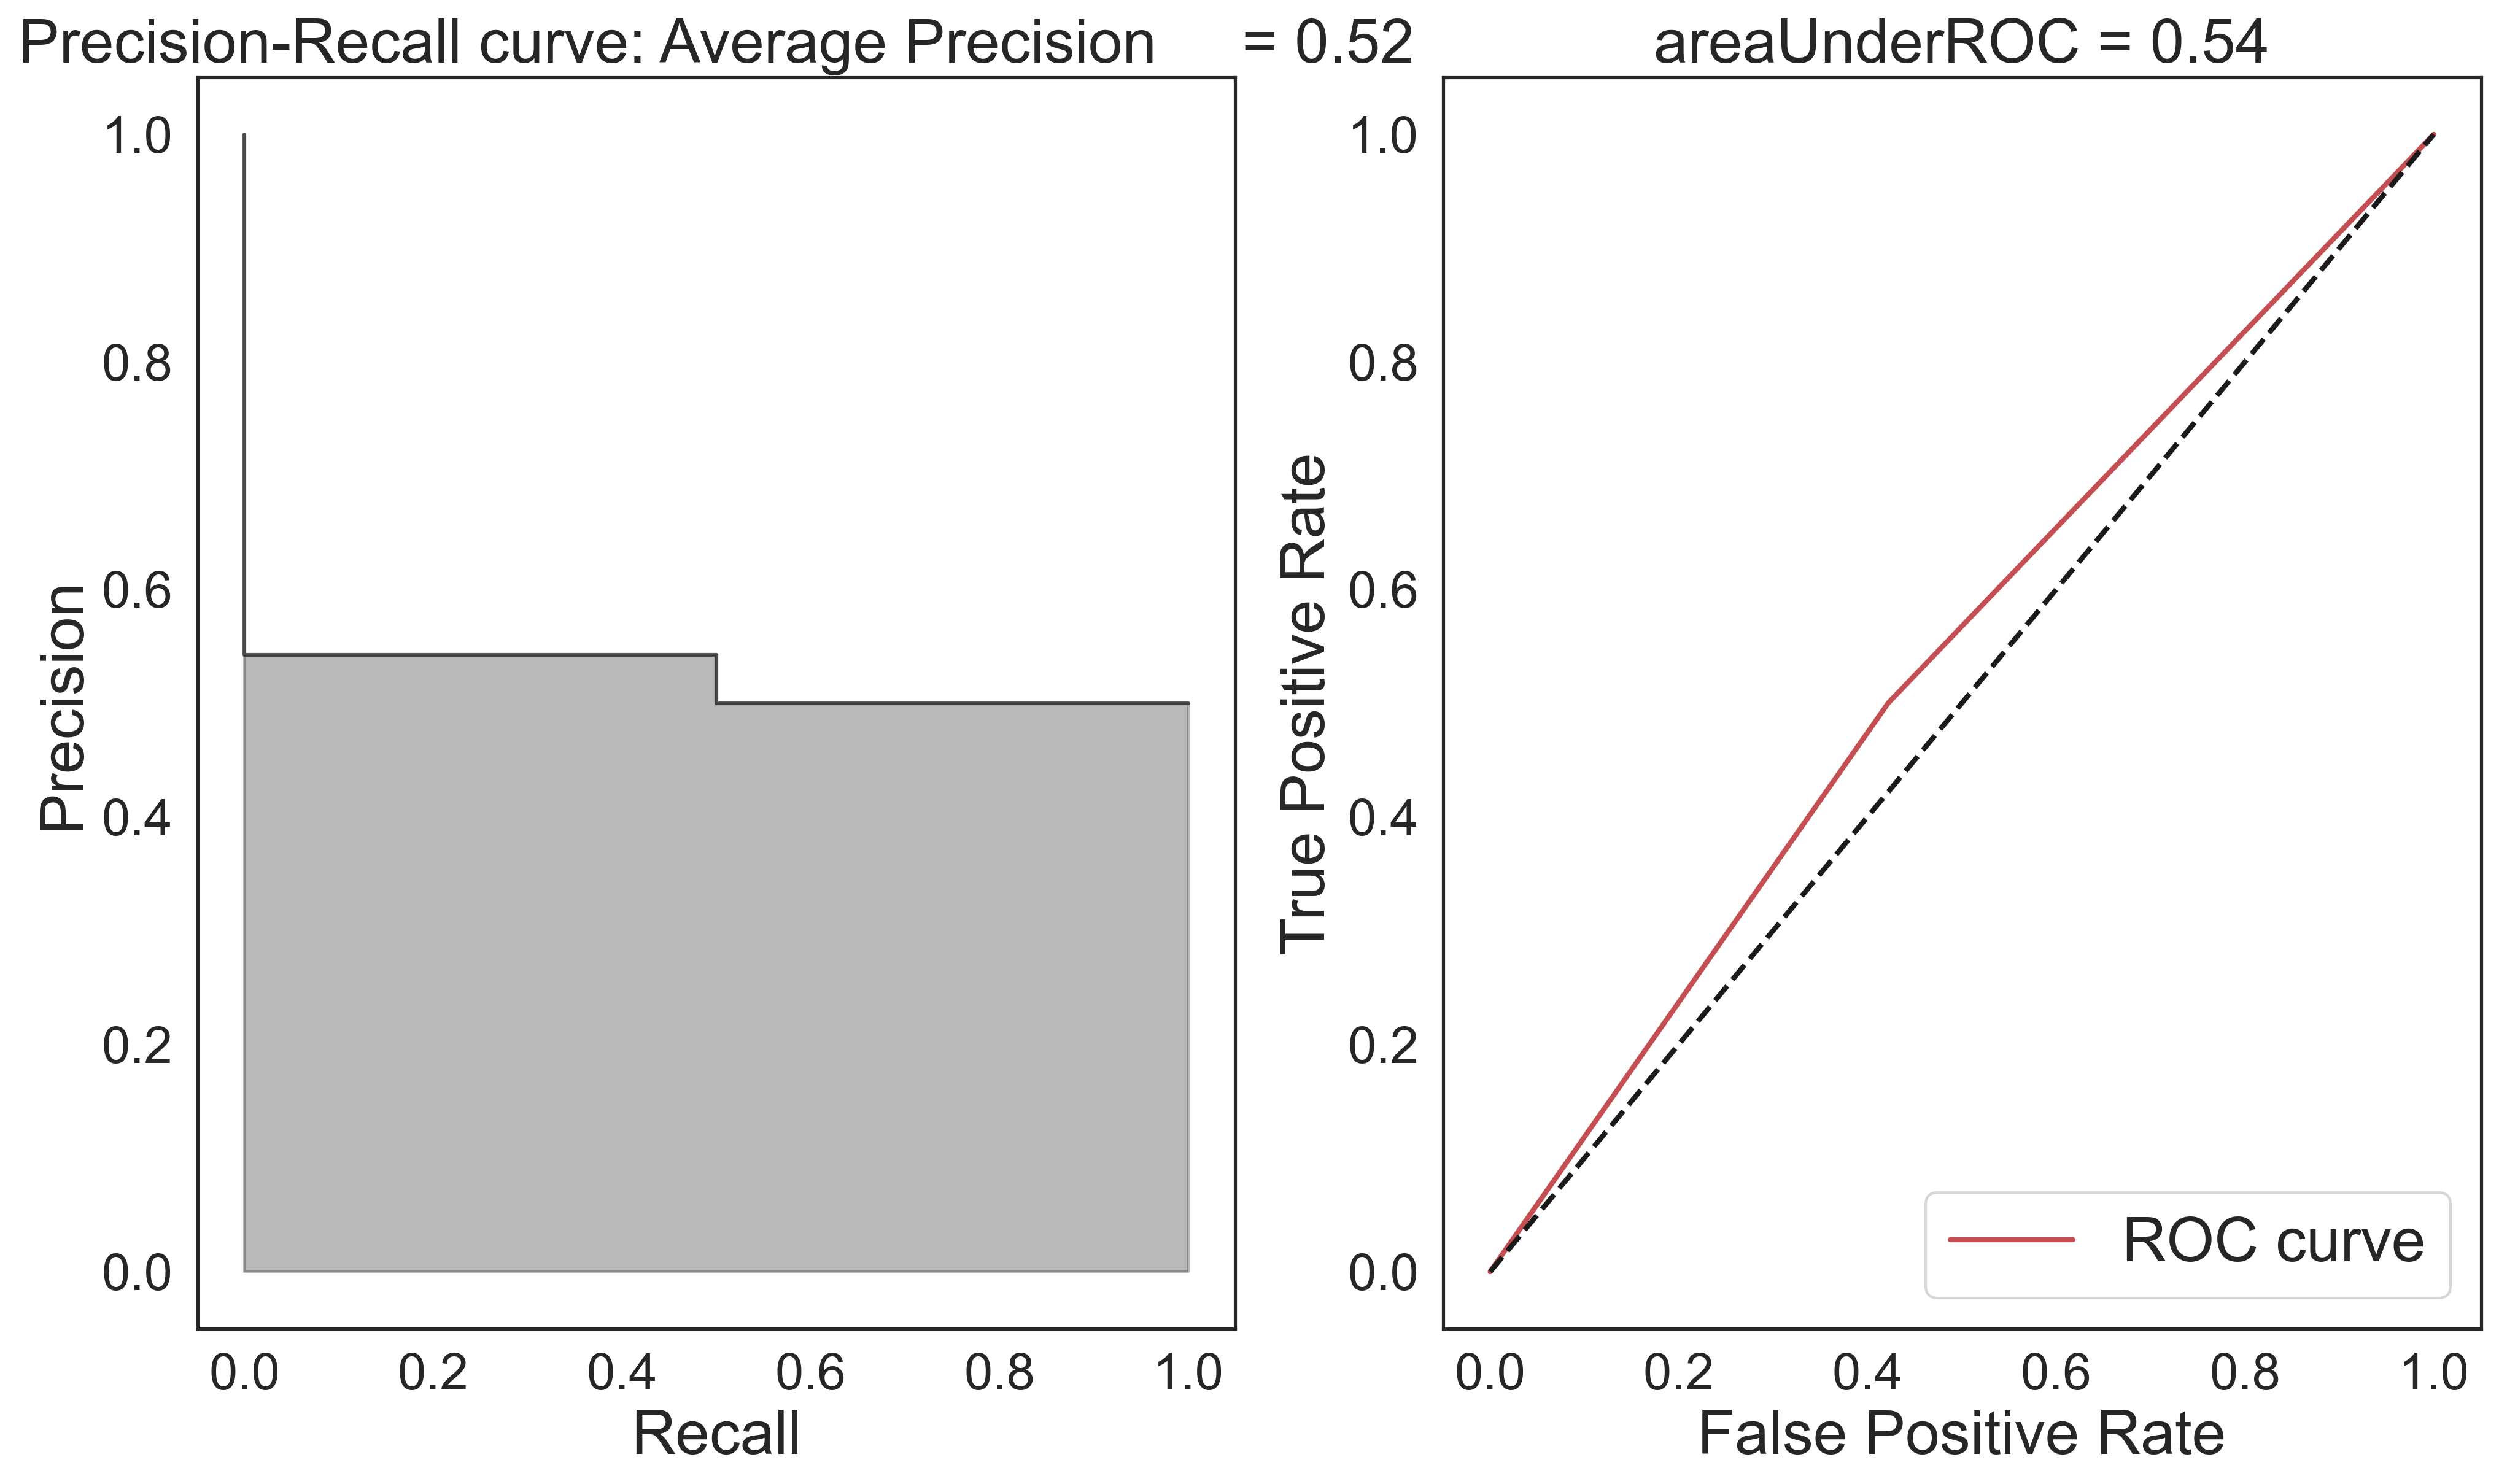

In [341]:
metrics_summary(y_test_original, y_pred_int_test_2_stack)

In [342]:
model_3_stack = build_model_3(x_train_stack_, y_train_)
y_pred_prob_test_3_stack = model_3_stack.predict(x_test_stack)
y_pred_int_test_3_stack = y_pred_prob_test_3_stack > Threshold
y_pred_int_test_3_stack.shape
pd.DataFrame(y_pred_int_test_3_stack).value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:56:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:56:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:56:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:56:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:56:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:56:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


False    69
True     59
dtype: int64

accuracy: 0.5390625
average_precision: 0.521186440677966
areaUnderROC: 0.5390625 

************************************************************
                     classification_report
************************************************************ 

              precision    recall  f1-score   support

           0       0.54      0.58      0.56        64
           1       0.54      0.50      0.52        64

    accuracy                           0.54       128
   macro avg       0.54      0.54      0.54       128
weighted avg       0.54      0.54      0.54       128

************************************************************
                     confusion_matrix 

************************************************************ 



array([[37, 27],
       [32, 32]], dtype=int64)

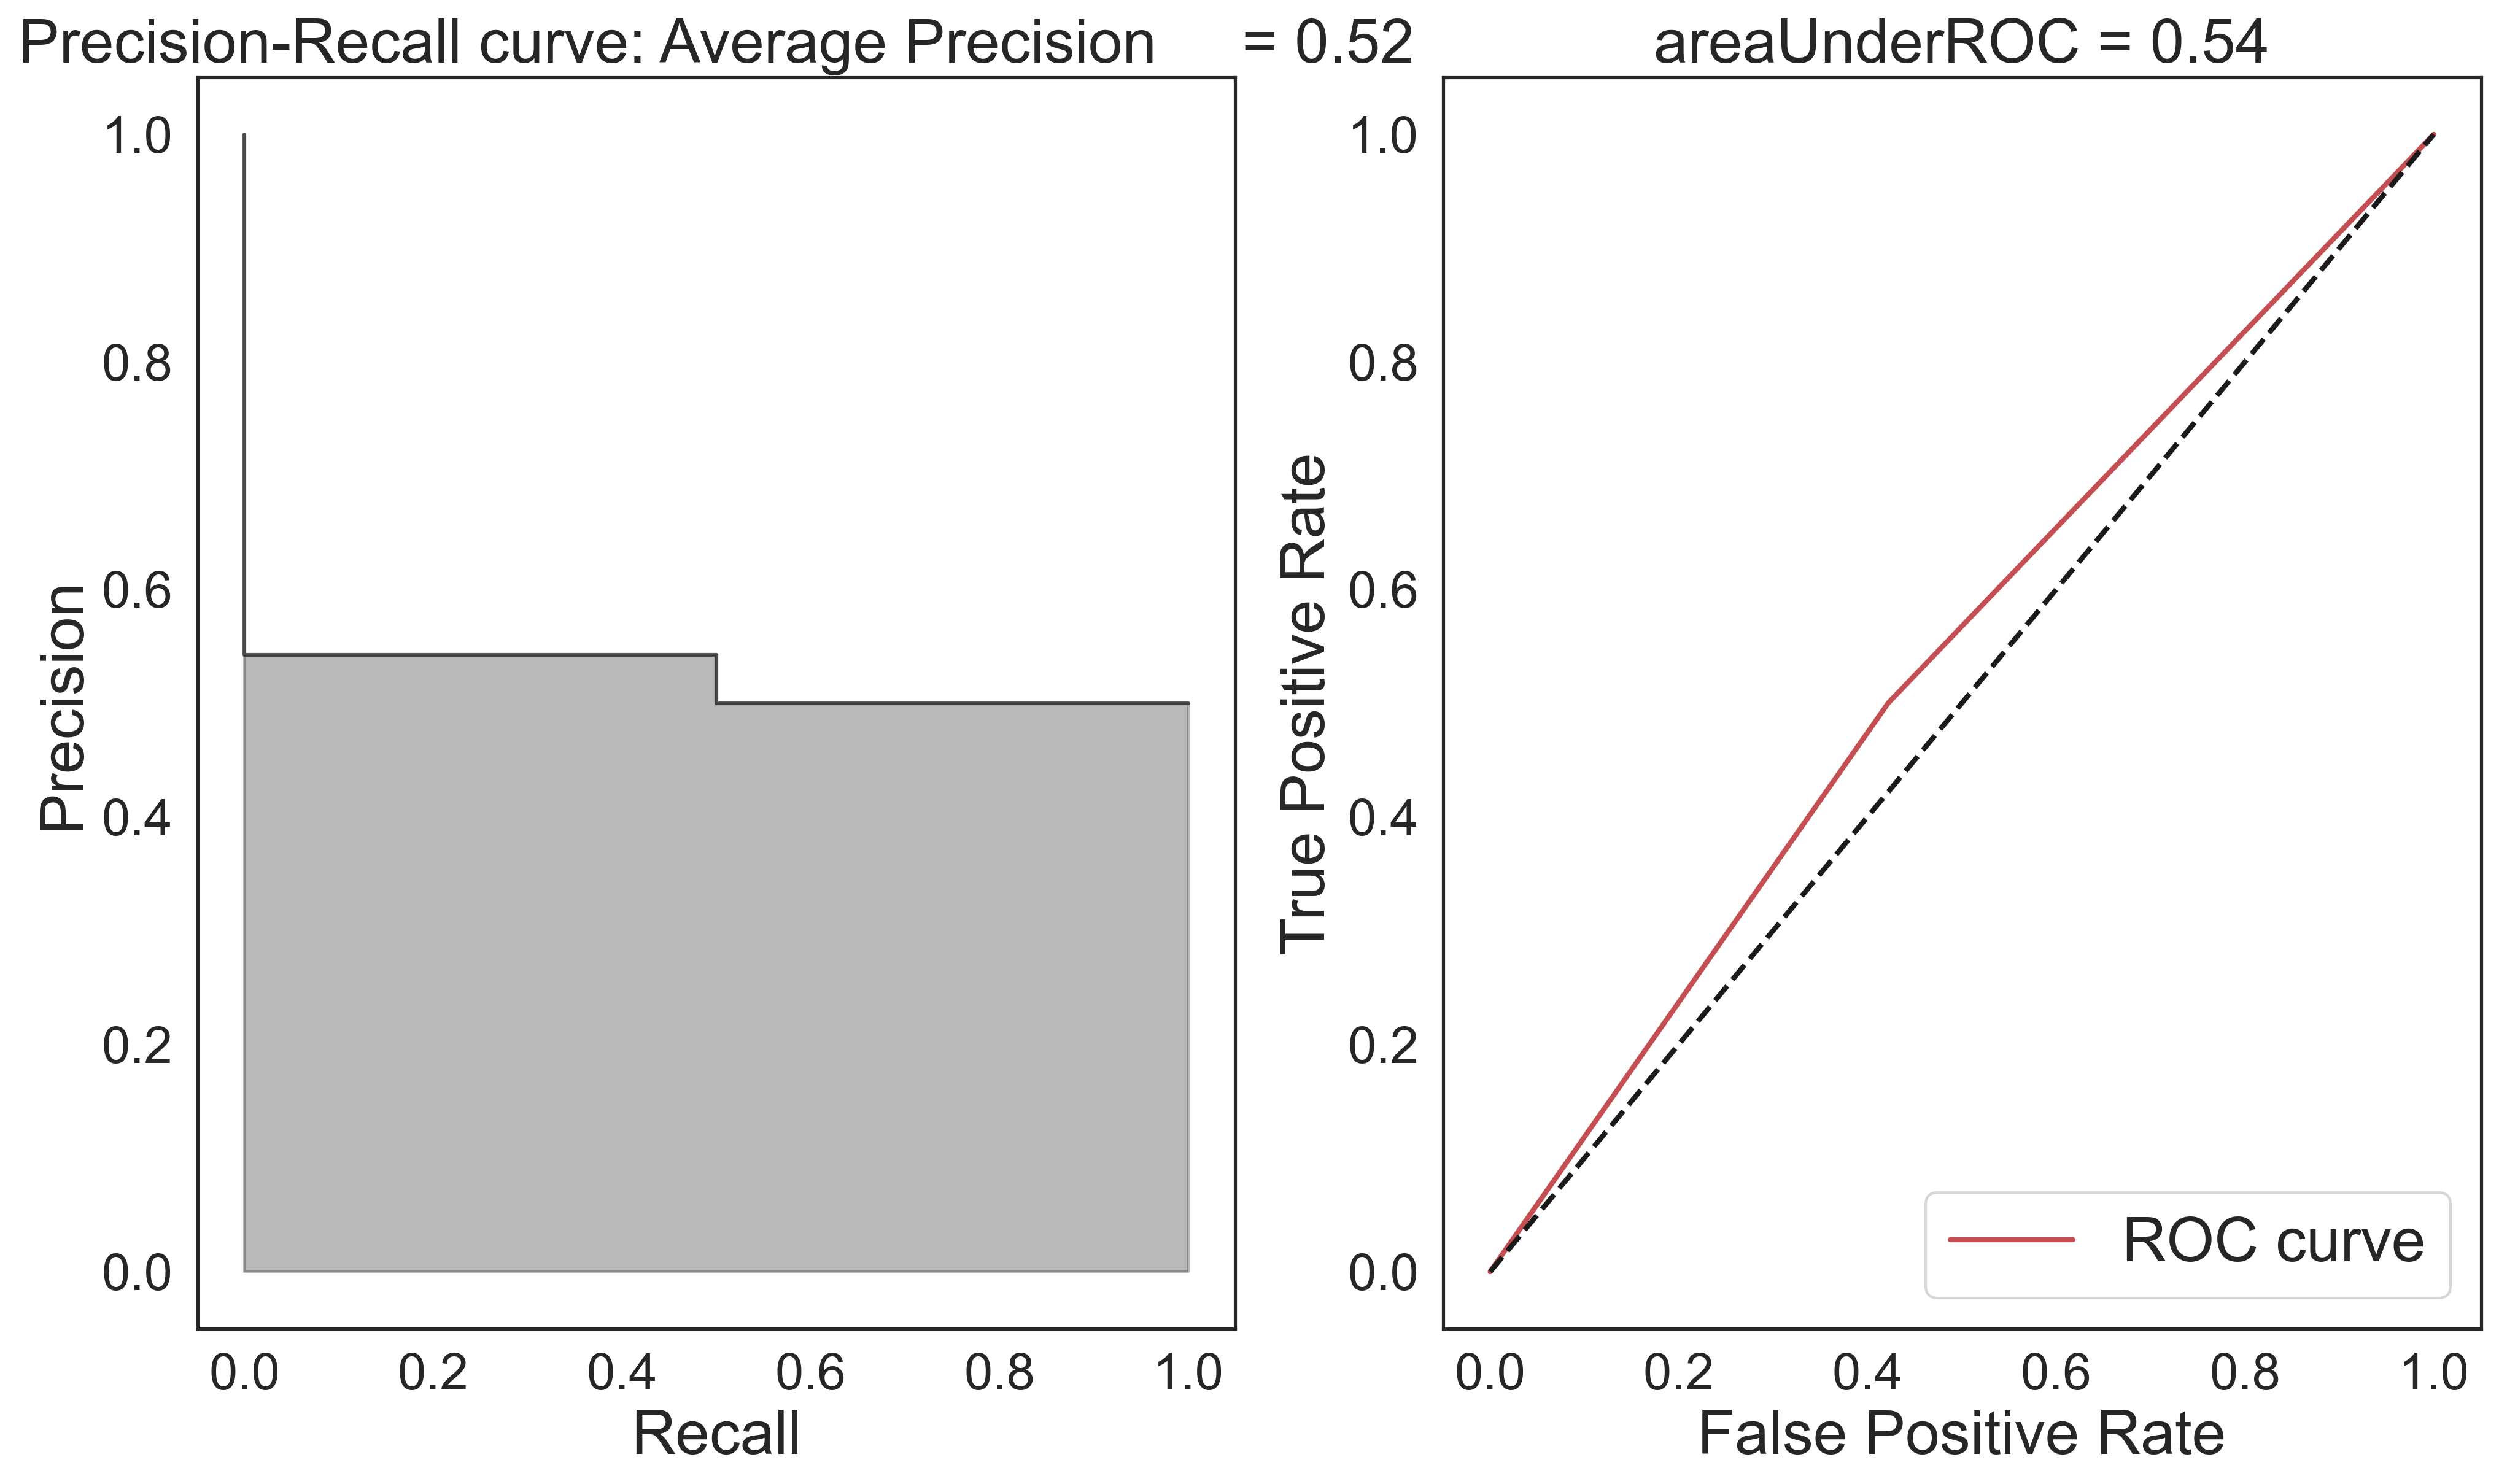

In [343]:
metrics_summary(y_test_original, y_pred_int_test_3_stack)

In [344]:
model_1_stack = build_model_1(x_train_stack, y_train)
model_1_stack.best_score_

0.9972602739726029

In [345]:
y_pred_prob_test_1_stack = model_1_stack.predict_proba(x_test_stack)[:,1]# 0 and 1 two clases
y_pred_int_test_1_stack = y_pred_prob_test_1_stack > Threshold
pd.Series(y_pred_int_test_1_stack).value_counts()

False    69
True     59
dtype: int64

accuracy: 0.5390625
average_precision: 0.521186440677966
areaUnderROC: 0.5390625 

************************************************************
                     classification_report
************************************************************ 

              precision    recall  f1-score   support

           0       0.54      0.58      0.56        64
           1       0.54      0.50      0.52        64

    accuracy                           0.54       128
   macro avg       0.54      0.54      0.54       128
weighted avg       0.54      0.54      0.54       128

************************************************************
                     confusion_matrix 

************************************************************ 



array([[37, 27],
       [32, 32]], dtype=int64)

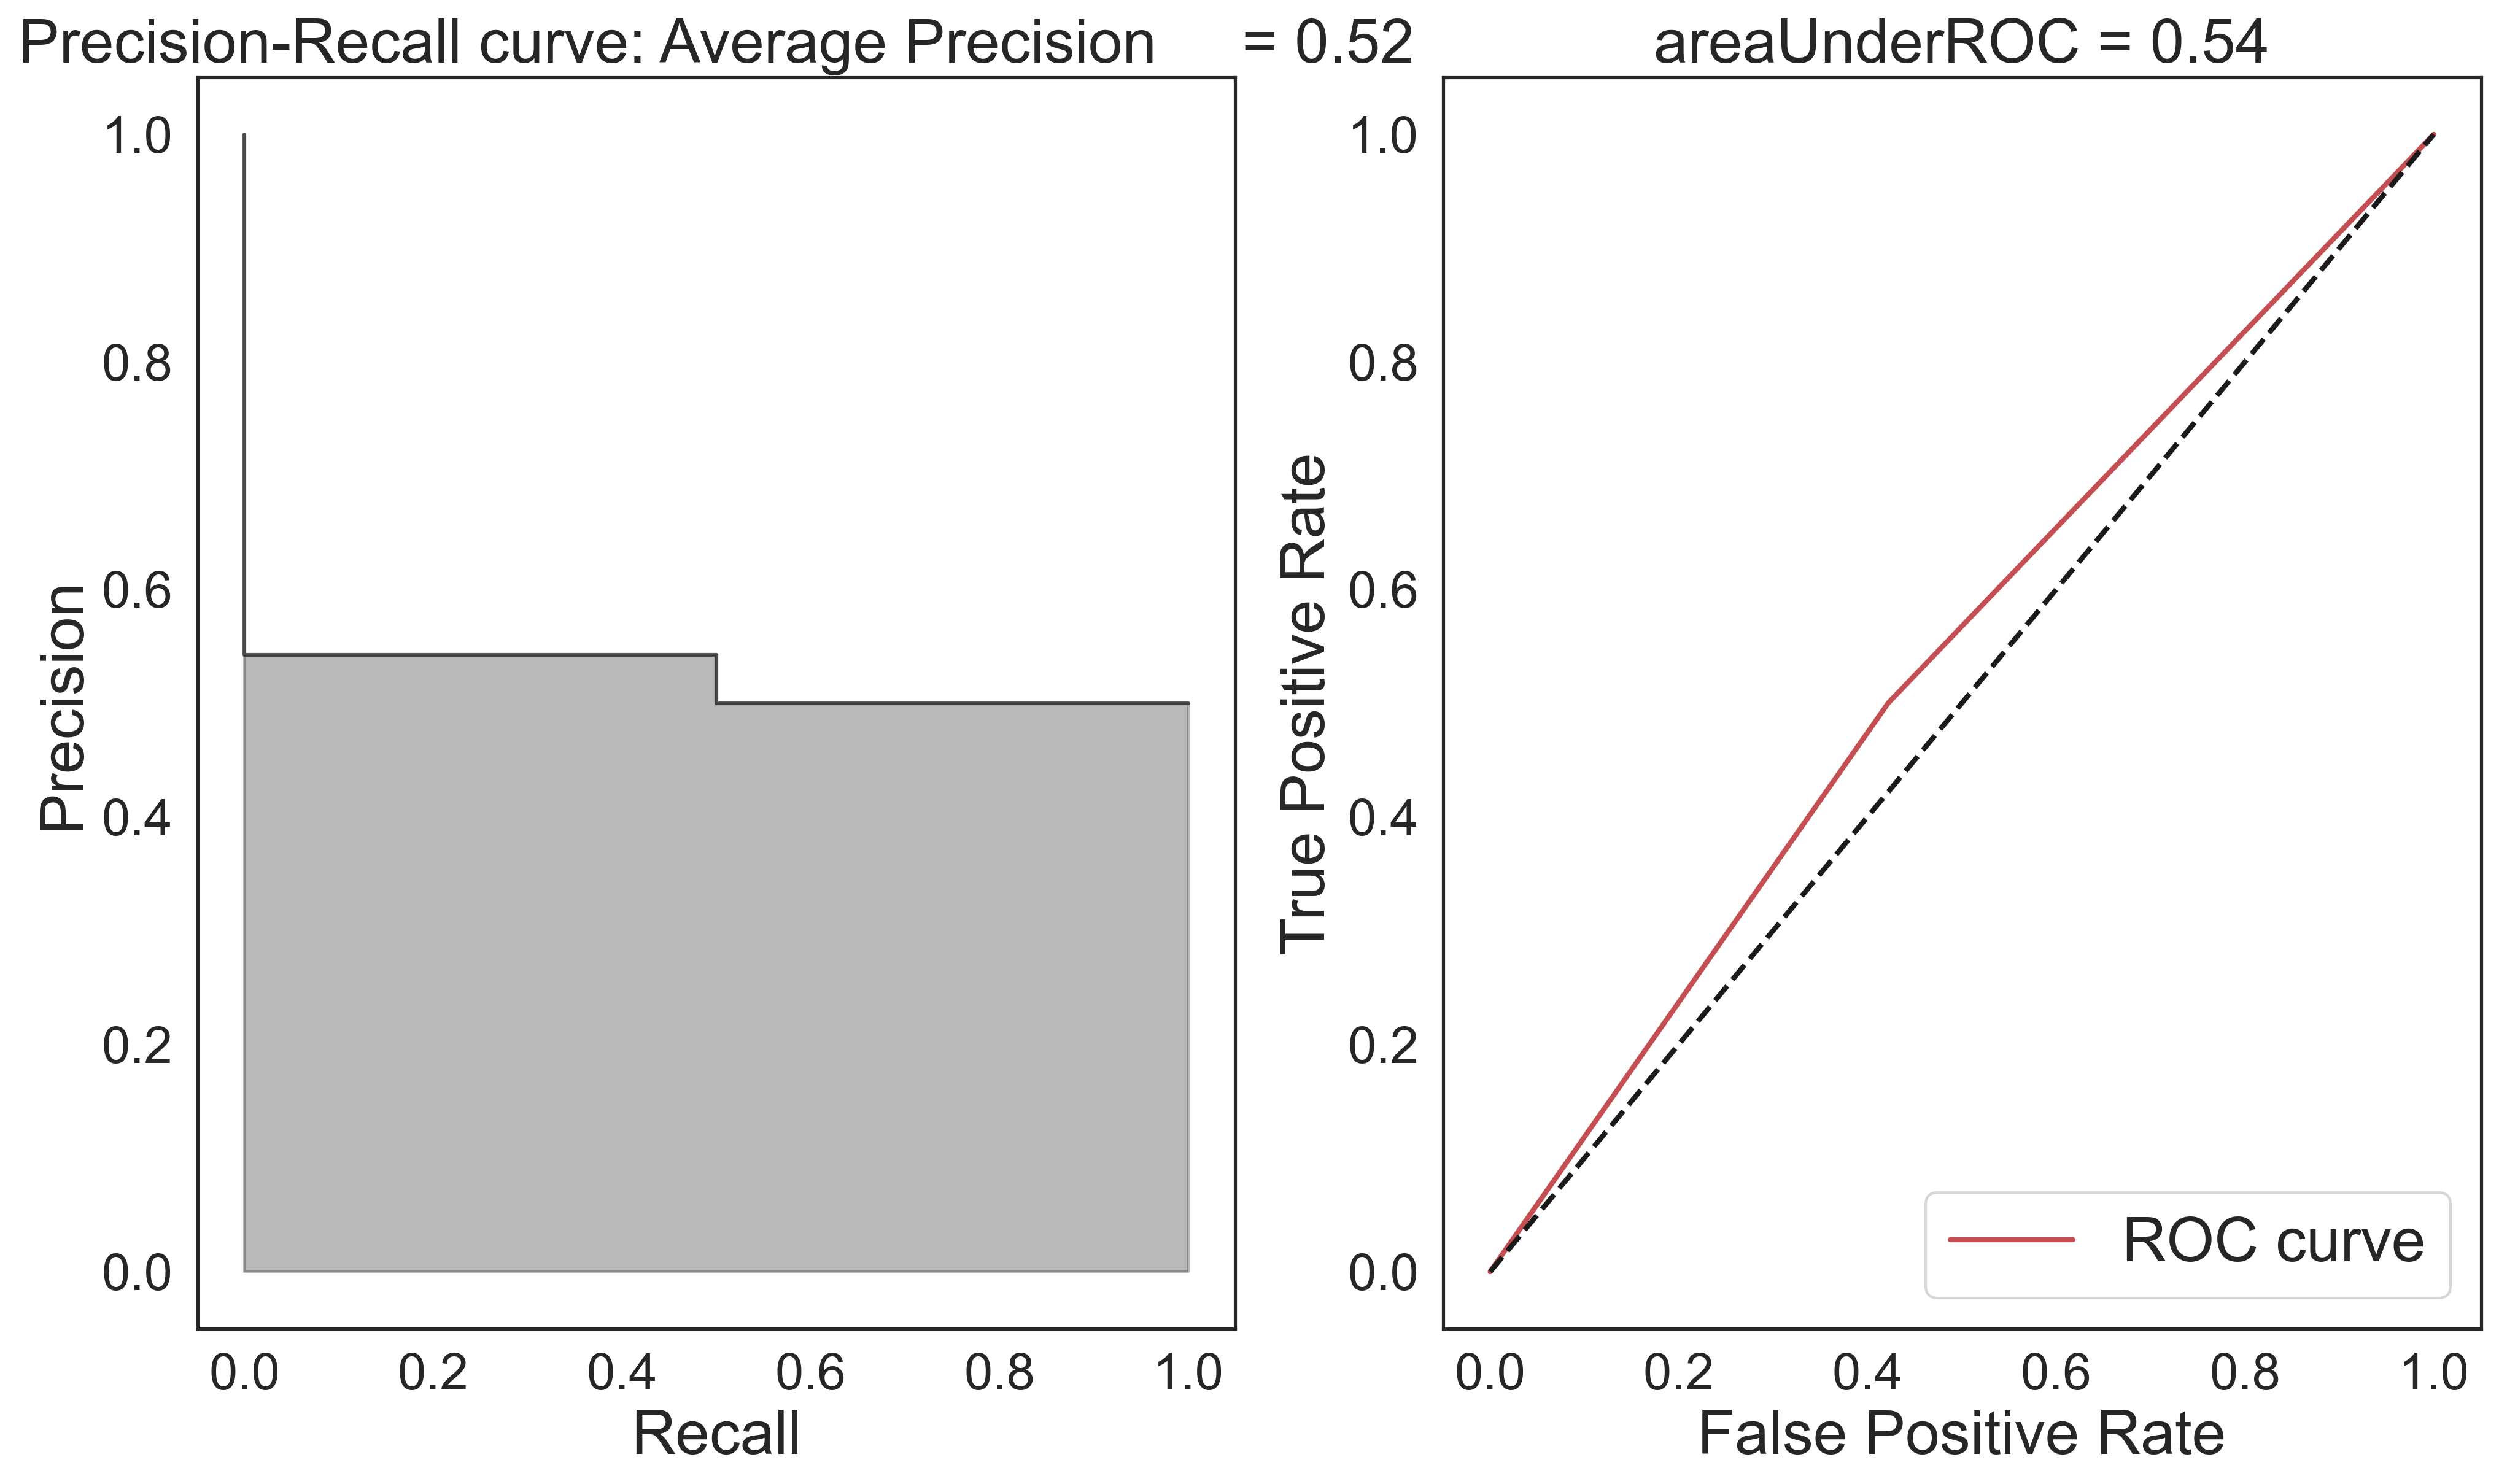

In [346]:
metrics_summary(y_test_original, y_pred_int_test_1_stack)

# Meta-labeling

In [347]:
def data_meta(id, x, y, model):
    #get prediction from model 1
    pred_prob_meta = model.predict_proba(x)[:,1]
    pred_prob_meta = pd.Series(pred_prob_meta, 
                               index=x.index,
                               name=f'pred_{id}_meta')
    pred_int_meta = pred_prob_meta > Threshold
    y_meta = pd.Series(y & pred_int_meta, name=f'y_train_meta_{id}')
    x_meta = x.join(pred_int_meta)
    
    return x_meta, y_meta
    pred_prob_meta = model.predict_proba(x)[:,1]
    pred_prob_meta = pd.Series(pred_prob_meta, 
                               index=x.index,
                               name=f'pred_{id}_meta')
    pred_int_meta = pred_prob_meta > Threshold
    y_meta = pd.Series(y & pred_int_meta, name=f'y_train_meta_{id}')
    x_meta = x.join(pred_int_meta)
    
    return x_meta, y_meta

In [348]:
x_train_meta_1, y_train_meta_1 = data_meta(1, x_train, y_train, model_1)
x_train_meta_1.shape, y_train_meta_1.shape

((381, 11), (381,))

In [349]:
# test data
x_test_meta_1, y_test_meta_1 = \
data_meta(1, x_test_original, y_test_original, model_1)
x_test_meta_1.shape, y_test_meta_1.shape

((128, 11), (128,))

In [350]:
x_train_meta_1, x_test_meta_1 = scale_data(x_train_meta_1, x_test_meta_1)

StandardScaler()


In [352]:
x_train_meta_1_, x_cv_meta_1, y_train_meta_1_, y_cv_meta_1 = train_test_split(x_train_meta_1, y_train_meta_1,
                test_size=0.25,
                stratify=y_train_meta_1,
                random_state=2020)
#stratify mean samplling with the ratio of each class percentage in #all data.
x_train_meta_1_.shape, x_cv_meta_1.shape, y_train_meta_1_.shape,  y_cv_meta_1.shape

((285, 11), (96, 11), (285,), (96,))

In [353]:
model_2_meta_1 = build_model_2(x_train_meta_1_, y_train_meta_1_, x_cv_meta_1, y_cv_meta_1)
y_pred_prob_test_2_meta_1 = model_2_meta_1.predict(x_test_meta_1)
y_pred_int_test_2_meta_1 = y_pred_prob_test_2_meta_1 > Threshold
pd.DataFrame(y_pred_int_test_2_meta_1).value_counts()

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

False    105
True      23
dtype: int64

In [354]:
final_pred_2_meta_1 = y_pred_int_test_2_meta_1 &  y_pred_int_test_1
pd.DataFrame(final_pred_2_meta_1).value_counts()

False    105
True      23
dtype: int64

accuracy: 0.4921875
average_precision: 0.49626358695652173
areaUnderROC: 0.4921875 

************************************************************
                     classification_report
************************************************************ 

              precision    recall  f1-score   support

           0       0.50      0.81      0.62        64
           1       0.48      0.17      0.25        64

    accuracy                           0.49       128
   macro avg       0.49      0.49      0.43       128
weighted avg       0.49      0.49      0.43       128

************************************************************
                     confusion_matrix 

************************************************************ 



array([[52, 12],
       [53, 11]], dtype=int64)

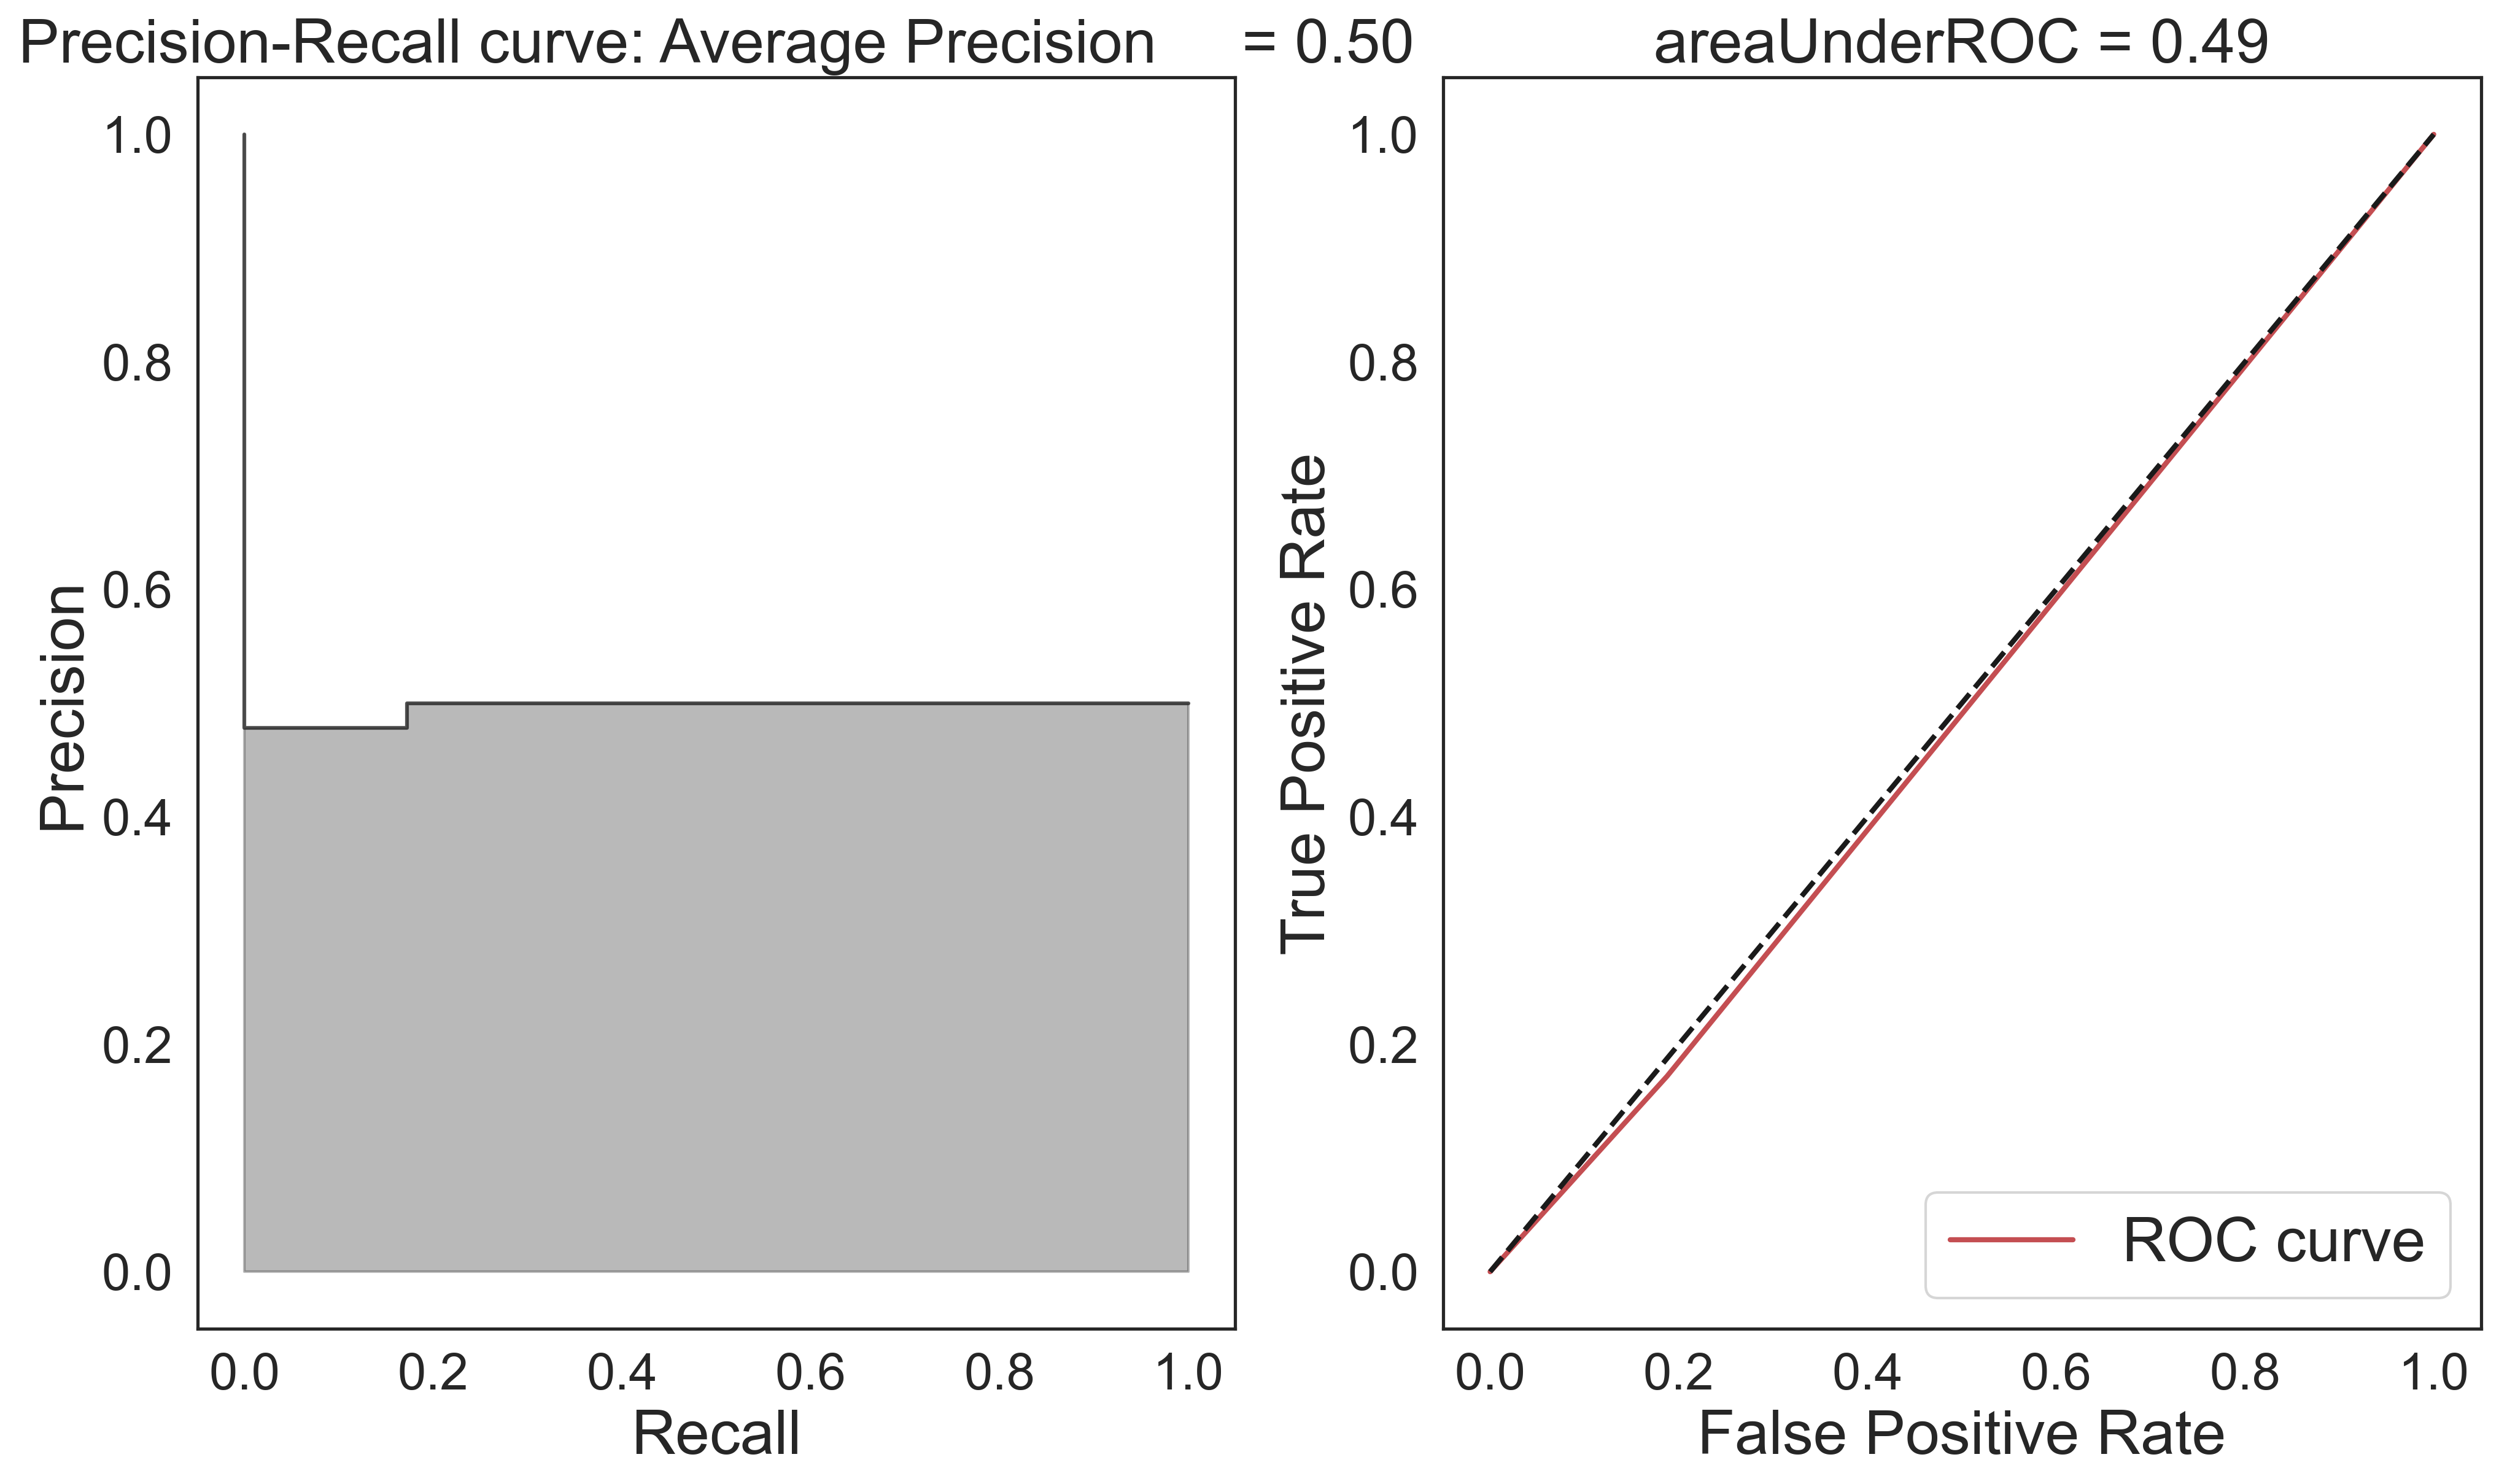

In [355]:
metrics_summary(y_test_original, final_pred_2_meta_1)

# Model 1 & Model 3

In [356]:
#if you receive an error message, try to run the data process again.
model_3_meta_1 = build_model_3(x_train_meta_1_, y_train_meta_1_)
y_pred_prob_test_3_meta_1 = model_3_meta_1.predict(x_test_meta_1)
y_pred_int_test_3_meta_1 = y_pred_prob_test_3_meta_1 > Threshold
pd.DataFrame(y_pred_int_test_3_meta_1).value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:58:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:58:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:58:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:58:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:58:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:58:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


False    113
True      15
dtype: int64

In [357]:
# combine the  meta prediction with primary prediction
final_pred_3_meta_1 = y_pred_int_test_3_meta_1.flatten() & y_pred_int_test_1
final_pred_3_meta_1.shape

(128,)

accuracy: 0.4921875
average_precision: 0.49635416666666665
areaUnderROC: 0.4921875 

************************************************************
                     classification_report
************************************************************ 

              precision    recall  f1-score   support

           0       0.50      0.88      0.63        64
           1       0.47      0.11      0.18        64

    accuracy                           0.49       128
   macro avg       0.48      0.49      0.40       128
weighted avg       0.48      0.49      0.40       128

************************************************************
                     confusion_matrix 

************************************************************ 



array([[56,  8],
       [57,  7]], dtype=int64)

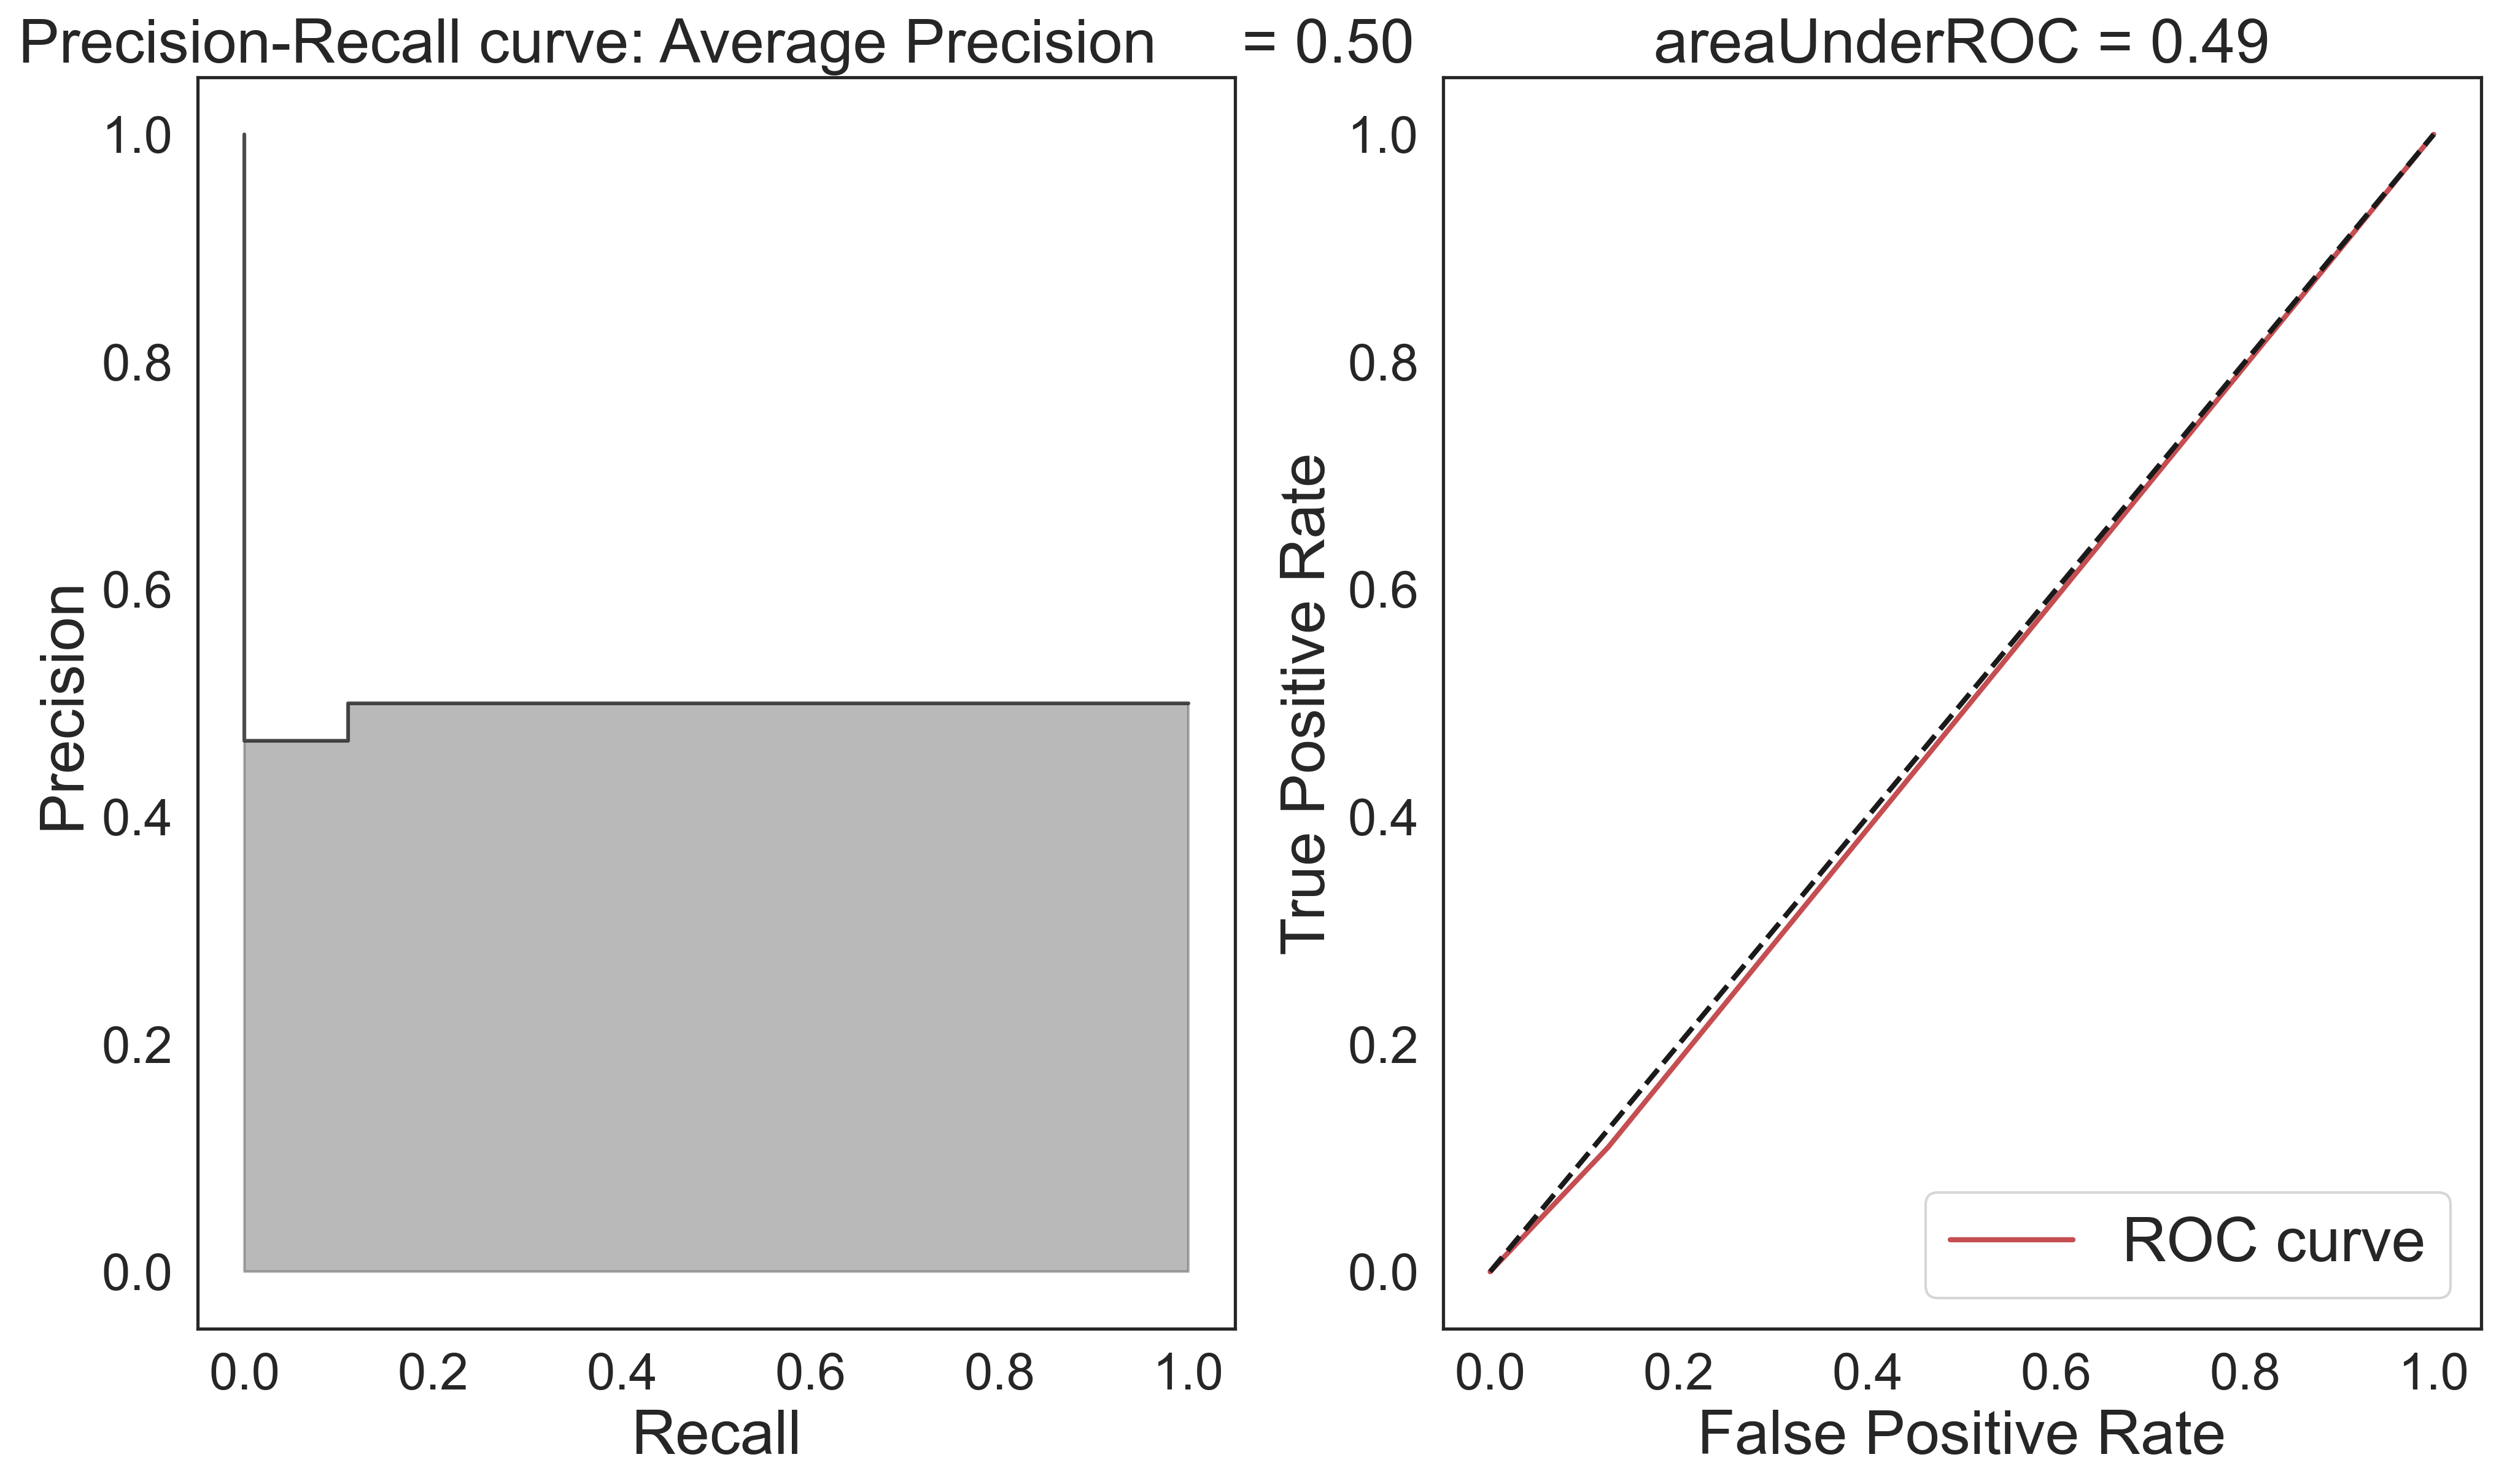

In [358]:
metrics_summary(y_test_original, final_pred_3_meta_1)

In [359]:
def plot_feature_importance(model, X , importance_type = 'split'):
    feature_imp = pd.DataFrame({'Value':model.
                               feature_importance(importance_type),
                               'Feature':X.columns})
    f, ax = plt.subplots(figsize=(40, 30))
    ax.set_title(f'LightGBM Features Importance by {importance_type}', fontsize=75, fontname="Arial")     
    ax.set_xlabel('Features', fontname="Arial", fontsize=70)
    ax.set_ylabel('Importance', fontname="Arial", fontsize=70)  
    ax.tick_params(labelsize=50)
    
    sns.barplot(x="Value", y="Feature",
                data=feature_imp.sort_values(by="Value", 
                ascending=False), ax=ax)

AttributeError: 'GridSearchCV' object has no attribute 'feature_importance_'